In [23]:
import os
import sys

# Ajouter le répertoire parent au sys.path
sys.path.append(os.path.abspath('..'))

import re
from collections import Counter

import en_core_web_sm
import pandas as pd
import polars as pl
import numpy as np
import plotly.express as px
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from spacy.lang.en.stop_words import STOP_WORDS

from training.helpers.text_processing import TextProcessing

pd.set_option('display.max_columns', None)


In [3]:
%time

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 4.53 μs


## Introduction et contexte

Ce notebook a pour but de faire une première exploration des données mises à disposition par openfoodfacts pour répondre à notre problème qui est:

quelle alternative à un produit alimentaire pourrait nous être proposé ?

Dans ces alternatives, quels sont les produits qui ne contiennent pas de produit susceptible de provoquer une allergie alimentaire ?

Le volume de données est important, nous allons nous concentrer sur les produits où la liste des ingrédients est renseignés et ou les produits sont vendus en france.

## Chargement des Données

In [4]:
rawdata = None
def extract_raw_data():
    file_path = '../data/raw/en.openfoodfacts.org.products.csv.gz'
    chunk_size = 10000

    filtered_chunks_list = []

    for chunk in pd.read_csv(file_path, chunksize=chunk_size, compression='gzip', sep='\t', engine='python', quoting=3):
        filtered_chunks = chunk[(chunk['countries_tags'].str.contains('en:france', na=False)) & (chunk['ingredients_tags'].notna())]
        filtered_chunks_list.append(filtered_chunks)

    if filtered_chunks_list:
        rawdata = pd.concat(filtered_chunks_list, axis=0)
    return rawdata

rawdata = extract_raw_data()
# rawdata = pd.read_csv('filtered_dataset_openfoodfacts_raw_en.csv')
display(rawdata)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,last_modified_by,last_updated_t,last_updated_datetime,product_name,abbreviated_product_name,generic_name,quantity,packaging,packaging_tags,packaging_en,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,ingredients_tags,ingredients_analysis_tags,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutrition_data,additives_n,additives,additives_tags,additives_en,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,food_groups,food_groups_tags,food_groups_en,states,states_tags,states_en,brand_owner,ecoscore_score,ecoscore_grade,nutrient_levels_tags,product_quantity,owner,data_quality_errors_tags,unique_scans_n,popularity_tags,completeness,last_image_t,last_image_datetime,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,butyric-acid_100g,caproic-acid_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,behenic-acid_100g,lignoceric-acid_100g,cerotic-acid_100g,montanic-acid_100g,melissic-acid_100g,unsaturated-fat_100g,monounsaturated-fat_100g,omega-9-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,omega-6-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,dihomo-gamma-linolenic-acid_100g,oleic-acid_100g,elaidic-acid_100g,gondoic-acid_100g,mead-acid_100g,erucic-acid_100g,nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,added-sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,erythritol_100g,fiber_100g,soluble-fiber_100g,insoluble-fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,added-salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g,sulphate_100g,nitrate_100g,acidity_100g
4,5,http://world-en.openfoodfacts.org/product/0000...,touchette,1605337720,2020-11-14T07:08:40Z,1729432954,2024-10-20T14:02:34Z,roboto-app,1.729433e+09,2024-10-20T14:02:34Z,Bio inulin,NaN,NaN,550g,Glass,en:glass,Glass,NaN,EWL,ewl,Gemüse,"en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo...",NaN,NaN,NaN,bénivay-ollon,benivay-ollon,en:no-lactose,en:no-lactose,No lactose,13089c,13089c,NaN,NaN,NaN,France,NaN,France,en:france,France,"Jus et purée d'abricots (50%), eau, sucre.","en:apricot-juice-and-puree,en:fruit,en:prunus-...","en:palm-oil-free,en:vegan,en:vegetarian",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

## Memory fine tuning

Différence entre pandas vs polars

In [21]:
%time
import tracemalloc

tracemalloc.start()
snapshot1 = tracemalloc.take_snapshot()
# Load the dataset
df = pd.read_csv("../data/production/database.csv")
snapshot2 = tracemalloc.take_snapshot()

stats = snapshot2.compare_to(snapshot1, "lineno")
for stat in stats[:10]:  # Afficher les 10 principales sources d'utilisation mémoire
    print(stat)

CPU times: user 8 μs, sys: 0 ns, total: 8 μs
Wall time: 13.4 μs


/tmp/ipykernel_183517/1610079311.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/production/database.csv")


/home/alexandre/workspace/projects/foodstuffs-recommendation/.venv/lib/python3.12/site-packages/pandas/io/parsers/c_parser_wrapper.py:234: size=1021 MiB (+1021 MiB), count=3629543 (+3629425), average=295 B
/home/alexandre/workspace/projects/foodstuffs-recommendation/.venv/lib/python3.12/site-packages/pandas/core/internals/managers.py:2301: size=115 MiB (+115 MiB), count=9 (+9), average=12.8 MiB
/home/alexandre/workspace/projects/foodstuffs-recommendation/.venv/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:133: size=7167 KiB (+7167 KiB), count=229347 (+229346), average=32 B
/usr/lib/python3.12/tokenize.py:576: size=0 B (-105 KiB), count=0 (-1921)
/usr/lib/python3.12/tracemalloc.py:558: size=152 KiB (+91.6 KiB), count=2867 (+1757), average=54 B
/home/alexandre/workspace/projects/foodstuffs-recommendation/.venv/lib/python3.12/site-packages/pandas/core/dtypes/base.py:147: size=0 B (-27.6 KiB), count=0 (-589)
<frozen genericpath>:89: size=34.1 KiB (-7664 B), count=327 (-97), ave

In [26]:
%time

dtypes = {
    "code": "string",
    "url": "string",
    "last_modified_t": "Int64",
    "product_name": "string",
    "packaging_tags": "string",
    "categories_tags": "string",
    "ingredients_tags": "string",
    "ingredients_analysis_tags": "string",
    "allergens": "string",
    "traces_tags": "string",
    "additives_tags": "string",
    "nutriscore_grade": "string",
    "food_groups_tags": "string",
    "states_tags": "string",
    "ecoscore_grade": "string",
    "nutrient_levels_tags": "string",
    "popularity_tags": "string",
    "main_category": "string",
    "image_url": "string",
    "image_small_url": "string",
    "energy_100g": "float64",
    "fat_100g": "float64",
    "saturated-fat_100g": "float64",
    "cholesterol_100g": "float64",
    "sugars_100g": "float64",
    "proteins_100g": "float64",
    "salt_100g": "float64",
    "fruits-vegetables-nuts-estimate-from-ingredients_100g": "float64",
    "last_modified_year": "Int32",
    "preprocessed_nutriscore_grade": "string",
    "preprocessed_ecoscore_grade": "string",
    "preprocessed_product_name": "string",
    "preprocessed_packaging_tags": "string",
    "preprocessed_packaging_tags_lemmatized": "string",
    "preprocessed_categories_tags": "string",
    "preprocessed_categories_tags_lemmatized": "string",
    "preprocessed_ingredients_tags": "string",
    "preprocessed_ingredients_tags_lemmatized": "string",
    "preprocessed_ingredients_analysis_tags": "string",
    "preprocessed_ingredients_analysis_tags_lemmatized": "string",
    "preprocessed_nutrient_levels_tags": "string",
    "preprocessed_nutrient_levels_tags_lemmatized": "string",
    "preprocessed_main_category": "string",
    "preprocessed_main_category_lemmatized": "string",
    "preprocessed_popularity_tags": "string",
    "preprocessed_popularity_tags_lemmatized": "string",
    "cluster_text": "string",
}

df = pd.read_csv("../data/production/database.csv", dtype=dtypes)
%time


CPU times: user 7 μs, sys: 0 ns, total: 7 μs
Wall time: 12.4 μs
CPU times: user 0 ns, sys: 11 μs, total: 11 μs
Wall time: 24.3 μs


In [32]:
%time
# Définition des types
dtypes = {
    "code": pl.Utf8,
    "url": pl.Utf8,
    "last_modified_t": pl.Int64,
    "product_name": pl.Utf8,
    "packaging_tags": pl.Utf8,
    "categories_tags": pl.Utf8,
    "ingredients_tags": pl.Utf8,
    "ingredients_analysis_tags": pl.Utf8,
    "allergens": pl.Utf8,
    "traces_tags": pl.Utf8,
    "additives_tags": pl.Utf8,
    "nutriscore_grade": pl.Utf8,
    "food_groups_tags": pl.Utf8,
    "states_tags": pl.Utf8,
    "ecoscore_grade": pl.Utf8,
    "nutrient_levels_tags": pl.Utf8,
    "popularity_tags": pl.Utf8,
    "main_category": pl.Utf8,
    "image_url": pl.Utf8,
    "image_small_url": pl.Utf8,
    "energy_100g": pl.Float32,
    "fat_100g": pl.Float32,
    "saturated-fat_100g": pl.Float32,
    "cholesterol_100g": pl.Float32,
    "sugars_100g": pl.Float32,
    "proteins_100g": pl.Float32,
    "salt_100g": pl.Float32,
    "fruits-vegetables-nuts-estimate-from-ingredients_100g": pl.Float32,
    "last_modified_year": pl.Int32,
    "preprocessed_nutriscore_grade": pl.Utf8,
    "preprocessed_ecoscore_grade": pl.Utf8,
    "preprocessed_product_name": pl.Utf8,
    "preprocessed_packaging_tags": pl.Utf8,
    "preprocessed_packaging_tags_lemmatized": pl.Utf8,
    "preprocessed_categories_tags": pl.Utf8,
    "preprocessed_categories_tags_lemmatized": pl.Utf8,
    "preprocessed_ingredients_tags": pl.Utf8,
    "preprocessed_ingredients_tags_lemmatized": pl.Utf8,
    "preprocessed_ingredients_analysis_tags": pl.Utf8,
    "preprocessed_ingredients_analysis_tags_lemmatized": pl.Utf8,
    "preprocessed_nutrient_levels_tags": pl.Utf8,
    "preprocessed_nutrient_levels_tags_lemmatized": pl.Utf8,
    "preprocessed_main_category": pl.Utf8,
    "preprocessed_main_category_lemmatized": pl.Utf8,
    "preprocessed_popularity_tags": pl.Utf8,
    "preprocessed_popularity_tags_lemmatized": pl.Utf8,
    "cluster_text": pl.Utf8,
}

# Chargement des données avec optimisation des types
df = pl.read_csv("../data/production/database.csv", schema_overrides=dtypes)

# Vérifiez les types après chargement
df.head()

CPU times: user 0 ns, sys: 10 μs, total: 10 μs
Wall time: 39.3 μs


code,url,last_modified_t,product_name,packaging_tags,categories_tags,ingredients_tags,ingredients_analysis_tags,allergens,traces_tags,additives_tags,nutriscore_grade,food_groups_tags,states_tags,ecoscore_grade,nutrient_levels_tags,popularity_tags,main_category,image_url,image_small_url,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,sugars_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,last_modified_year,preprocessed_nutriscore_grade,preprocessed_ecoscore_grade,preprocessed_product_name,preprocessed_packaging_tags,preprocessed_packaging_tags_lemmatized,preprocessed_categories_tags,preprocessed_categories_tags_lemmatized,preprocessed_ingredients_tags,preprocessed_ingredients_tags_lemmatized,preprocessed_ingredients_analysis_tags,preprocessed_ingredients_analysis_tags_lemmatized,preprocessed_nutrient_levels_tags,preprocessed_nutrient_levels_tags_lemmatized,preprocessed_main_category,preprocessed_main_category_lemmatized,preprocessed_popularity_tags,preprocessed_popularity_tags_lemmatized,cluster_text
str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f32,f32,f32,f32,f32,f32,f32,f32,i32,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""5""","""http://world-en.openfoodfacts.…",1729432954,"""Bio inulin""","""en:glass""","""en:plant-based-foods-and-bever…","""en:apricot-juice-and-puree,en:…","""en:palm-oil-free,en:vegan,en:v…","""en:none""","""en:none""","""en:none""","""a""","""en:fruits-and-vegetables,en:ve…","""en:to-be-completed,en:nutritio…","""unknown""","""en:fat-in-low-quantity,en:satu…","""unknown""","""en:vegetables""","""https://images.openfoodfacts.o…","""https://images.openfoodfacts.o…",-0.001767,-0.725799,-0.591608,-0.096619,-0.230722,-0.808852,-0.106865,0.684736,2024,"""-0.7303793902769964""","""-1.013833108259419""","""bio inulin""","""glass""","""glass""","""plant based foods and beverage…","""plant base food beverage plant…","""apricot juice and puree fruit …","""apricot juice puree fruit prun…","""palm oil free vegan vegetarian""","""palm oil free vegan vegetarian""","""fat in low quantity saturated …","""fat low quantity saturate fat …","""vegetables""","""vegetable""","""unknown""","""unknown""","""417"""
"""10""","""http://world-en.openfoodfacts.…",1728034727,"""Madeleines nature""","""en:plastic,en:cardboard,fr:boi…","""en:snacks,en:desserts,en:sweet…","""en:wheat-flour,en:cereal,en:fl…","""en:palm-oil-free,en:non-vegan,…","""en:eggs,en:gluten,en:milk""","""en:nuts,en:soybeans""","""en:e331,en:e422,en:e503""","""d""","""en:sugary-snacks,en:biscuits-a…","""en:to-be-completed,en:nutritio…","""c""","""en:fat-in-high-quantity,en:sat…","""top-50000-scans-2019,top-10000…","""en:plain-madeleines""","""https://images.openfoodfacts.o…","""https://images.openfoodfacts.o…",-0.001767,0.584987,-0.2581,-0.096619,0.647621,-0.098427,-0.060826,0.084919,2024,"""0.8843707646118961""","""0.7145747153944271""","""madeleines nature""","""plastic cardboard boite en car…","""plastic cardboard boite en car…","""snacks desserts sweet snacks b…","""snack dessert sweet snack bisc…","""wheat flour cereal flour wheat…","""wheat flour cereal flour wheat…","""palm oil free non vegan vegeta…","""palm oil free non vegan vegeta…","""fat in high quantity saturated…","""fat high quantity saturate fat…","""plain madeleines""","""plain madeleine""","""top 50000 scans 2019top 100000…","""50000 scan 2019top 100000 scan…","""161"""
"""15""","""http://world-en.openfoodfacts.…",1728034730,"""Madeleines ChocoLait""","""en:plastic,en:cardboard""","""en:snacks,en:sweet-snacks,en:b…","""en:wheat-flour,en:cereal,en:fl…","""en:palm-oil-free,en:non-vegan,…","""en:none""","""en:nuts""","""en:e322,en:e322i,en:e331,en:e4…","""d""","""en:sugary-snacks,en:biscuits-a…","""en:to-be-completed,en:nutritio…","""d""","""en:fat-in-high-quantity,en:sat…","""top-50000-scans-2019,top-10000…","""en:chocolate-madeleines""","""https://images.openfoodfacts.o…","""https://images.ope

In [33]:
df.columns

['code',
 'url',
 'last_modified_t',
 'product_name',
 'packaging_tags',
 'categories_tags',
 'ingredients_tags',
 'ingredients_analysis_tags',
 'allergens',
 'traces_tags',
 'additives_tags',
 'nutriscore_grade',
 'food_groups_tags',
 'states_tags',
 'ecoscore_grade',
 'nutrient_levels_tags',
 'popularity_tags',
 'main_category',
 'image_url',
 'image_small_url',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'cholesterol_100g',
 'sugars_100g',
 'proteins_100g',
 'salt_100g',
 'fruits-vegetables-nuts-estimate-from-ingredients_100g',
 'last_modified_year',
 'preprocessed_nutriscore_grade',
 'preprocessed_ecoscore_grade',
 'preprocessed_product_name',
 'preprocessed_packaging_tags',
 'preprocessed_packaging_tags_lemmatized',
 'preprocessed_categories_tags',
 'preprocessed_categories_tags_lemmatized',
 'preprocessed_ingredients_tags',
 'preprocessed_ingredients_tags_lemmatized',
 'preprocessed_ingredients_analysis_tags',
 'preprocessed_ingredients_analysis_tags_lemmatized',
 'prepr

In [45]:
NUMERIC_COLUMNS = [
    "energy_100g",
    "fat_100g",
    "saturated-fat_100g",
    "cholesterol_100g",
    "sugars_100g",
    "proteins_100g",
    "salt_100g",
    "fruits-vegetables-nuts-estimate-from-ingredients_100g",
    "preprocessed_nutriscore_grade",
    "preprocessed_ecoscore_grade",
]

product_cluster = (
    df.filter(df["code"] == "7622210449283").select("cluster_text").to_numpy()[0][0]
)
target_features = (
    df.filter(df["code"] == "7622210449283").select(NUMERIC_COLUMNS).to_numpy()[0]
)

# Chargement des données avec optimisation des types
encoded_categorical_features = pl.read_csv("../data/production/categorical_features.csv")

print(f"Nombre de lignes de df: {df.height}")
print(f"Nombre de lignes de encoded_categorical_features: {encoded_categorical_features.height}")

df = df.with_columns([pl.col("cluster_text").cast(pl.Utf8)])

# cluster_features_combined = df.hstack(encoded_categorical_features)
# cluster_features_combined = pl.concat([df, encoded_categorical_features], how="horizontal")
cluster_features_combined = df.hstack(encoded_categorical_features)

similar_cluster_products = cluster_features_combined.filter(
    pl.col("cluster_text") == product_cluster
)



# Vérifiez les types après chargement
cluster_features_combined.head()

Nombre de lignes de df: 320441
Nombre de lignes de encoded_categorical_features: 320441


code,url,last_modified_t,product_name,packaging_tags,categories_tags,ingredients_tags,ingredients_analysis_tags,allergens,traces_tags,additives_tags,nutriscore_grade,food_groups_tags,states_tags,ecoscore_grade,nutrient_levels_tags,popularity_tags,main_category,image_url,image_small_url,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,sugars_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,last_modified_year,preprocessed_nutriscore_grade,preprocessed_ecoscore_grade,preprocessed_product_name,preprocessed_packaging_tags,preprocessed_packaging_tags_lemmatized,preprocessed_categories_tags,preprocessed_categories_tags_lemmatized,preprocessed_ingredients_tags,…,13_duplicated_3,14_duplicated_3,15_duplicated_3,16_duplicated_3,17_duplicated_3,18_duplicated_3,19_duplicated_3,20_duplicated_3,21_duplicated_3,22_duplicated_3,23_duplicated_3,24_duplicated_3,25_duplicated_3,26_duplicated_3,27_duplicated_3,28_duplicated_3,29_duplicated_3,30_duplicated_3,31_duplicated_3,32_duplicated_3,33_duplicated_3,34_duplicated_3,35_duplicated_3,36_duplicated_3,37_duplicated_3,38_duplicated_3,39_duplicated_3,40_duplicated_3,41_duplicated_3,42_duplicated_3,43_duplicated_3,44_duplicated_3,45_duplicated_3,46_duplicated_3,47_duplicated_3,48_duplicated_3,49_duplicated_3
str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f32,f32,f32,f32,f32,f32,f32,f32,i32,str,str,str,str,str,str,str,str,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""5""","""http://world-en.openfoodfacts.…",1729432954,"""Bio inulin""","""en:glass""","""en:plant-based-foods-and-bever…","""en:apricot-juice-and-puree,en:…","""en:palm-oil-free,en:vegan,en:v…","""en:none""","""en:none""","""en:none""","""a""","""en:fruits-and-vegetables,en:ve…","""en:to-be-completed,en:nutritio…","""unknown""","""en:fat-in-low-quantity,en:satu…","""unknown""","""en:vegetables""","""https://images.openfoodfacts.o…","""https://images.openfoodfacts.o…",-0.001767,-0.725799,-0.591608,-0.096619,-0.230722,-0.808852,-0.106865,0.684736,2024,"""-0.7303793902769964""","""-1.013833108259419""","""bio inulin""","""glass""","""glass""","""plant based foods and beverage…","""plant base food beverage plant…","""apricot juice and puree fruit …",…,0.026185,-0.0438,-0.062428,0.056745,-0.053251,0.113197,0.138325,-0.102821,0.22767,-0.382655,0.530923,0.18395,-0.05892,-0.267353,-0.019259,-0.006673,0.098004,0.013308,0.001566,0.016477,-0.014062,0.013328,0.002075,-0.011987,0.05615,-0.038402,-0.099046,-0.014037,-0.025653,0.057716,0.048046,-0.064223,0.043101,-0.137118,-0.264151,0.201911,-0.036879
"""10""","""http://world-en.openfoodfacts.…",1728034727,"""Madeleines nature""","""en:plastic,en:cardboard,fr:boi…","""en:snacks,en:desserts,en:sweet…","""en:wheat-flour,en:cereal,en:fl…","""en:palm-oil-free,en:non-vegan,…","""en:eggs,en:gluten,en:milk""","""en:nuts,en:soybeans""","""en:e331,en:e422,en:e503""","""d""","""en:sugary-snacks,en:biscuits-a…","""en:to-be-completed,en:nutritio…","""c""","""en:fat-in-high-quantity,en:sat…","""top-50000-scans-2019,top-10000…","""en:plain-madeleines""","""https://images.openfoodfacts.o…","""https://images.openfoodfacts.o…",-0.001767,0.584987,-0.2581,-0.096619,0.647621,-0.098427,-0.060826,0.084919,2024,"""0.8843707646118961""","""0.7145747153944271""","""madeleines nature""","""plastic cardboard boite en car…","""plastic cardboard boite en car…","""snacks desserts sweet snacks b…","""snack dessert sweet snack bisc…","""wheat flour cereal flour wheat…",…,0.000372,0.116721,0.089246,-0.012053,0.072915,0.019548,0.065104,0.017601,-0.011039,-0.047481,-0.01279,0.009248,0.010923,0.004406,0.009082,-0.023252,-0.006239,0.005063,0.017593,0.012191,0.004815,0.01193,0.003009,0.019458,-0.026554,0.018211,0.009586,0.045186,-0.005359,0.029128,-0.064805,0.029274,0.03601,0.037526,0.028688,0.014489,-0.055046
"""15""","""http://world-en.openfoodfacts.…",172803473

## Inspection des Données Brutes

In [5]:
# Basic stats
print("Taille du dataset:")
print("Number of rows : {}".format(rawdata.shape[0]))
print("Number of columns : {}".format(rawdata.shape[1]))
print()
print("---------------------------")
print()

print("Basics infos:")
print()
display(rawdata.info())
print()
print("---------------------------")
print()

print("Basics statistics: ")
print()
data_desc = rawdata.describe(include='all')
display(data_desc)
print()
print("---------------------------")
print()

print("Unique elements by feature: ")
print()
display(rawdata.nunique().sort_values())
print()
print("---------------------------")
print()

print("Percentage of missing values: ")
print()
null_percentage = 100 * rawdata.isnull().mean()
null_percentage_df = null_percentage.to_frame(name='Null Percentage').T
display(null_percentage_df) 

Taille du dataset:


NameError: name 'rawdata' is not defined

**Notes :**

Il y a beaucoup de données manquantes.

Nous allons dans un premier temps nous concentrer sur les données des produits vendus en France.

## Analyse Exploratoire des Données

In [ ]:
# Find different states
unique_values = set()
rawdata['states_tags'].str.split(',').apply(unique_values.update)

states_df = pd.DataFrame(data=unique_values, columns=['states'])
display(states_df)

,states
0,en:photos-uploaded
1,en:quantity-completed
2,en:product-name-to-be-completed
3,en:ingredients-photo-to-be-selected
4,en:categories-to-be-completed
5,en:packaging-photo-selected
6,en:ingredients-to-be-completed
7,en:nutrition-photo-to-be-selected
8,en:nutrition-facts-to-be-completed
9,en:origins-completed


In [ ]:
# Vérifier que la colonne 'state' existe
if 'state' in rawdata.columns:
    # Compter les occurrences de chaque état
    states_count = rawdata['state'].value_counts().reset_index()
    states_count.columns = ['state', 'count']
    
    # Afficher le tableau
    print(states_count)
else:
    print("La colonne 'state' n'existe pas dans le dataset.")

La colonne 'state' n'existe pas dans le dataset.


**Notes :**

Il y a beaucoup de colonnes, nous allons sélectionner celles qui potentiellement pourront aider nos futurs modèles à apprendre et à répondre à notre problématique.

In [ ]:
columns_to_keep = [
    'code',
    'url',
    'created_datetime',
    'last_modified_datetime',
    'product_name',
    'packaging_tags',
    'categories_tags',
    'ingredients_tags',
    'ingredients_analysis_tags',
    'allergens',
    'traces_tags',
    'additives_n',
    'additives_tags',
    'food_groups_tags',
    'states_tags',
    'nutriscore_grade',
    'ecoscore_grade',
    'nutrient_levels_tags',
    'popularity_tags',
    'main_category',
    'image_url',
    'image_small_url',
    'image_ingredients_url',
    'image_ingredients_small_url',
    'image_nutrition_url',
    'image_nutrition_small_url',
    'energy-kcal_100g',
    'energy_100g',
    'fat_100g',
    'saturated-fat_100g',
    'cholesterol_100g',
    'sugars_100g',
    'proteins_100g',
    'salt_100g',
    'fruits-vegetables-nuts-estimate-from-ingredients_100g'
]

data = rawdata[columns_to_keep]
display(data)

,code,url,created_datetime,last_modified_datetime,product_name,packaging_tags,categories_tags,ingredients_tags,ingredients_analysis_tags,allergens,traces_tags,additives_n,additives_tags,food_groups_tags,states_tags,nutriscore_grade,ecoscore_grade,nutrient_levels_tags,popularity_tags,main_category,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,sugars_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
4,5,http://world-en.openfoodfacts.org/product/0000...,2020-11-14T07:08:40Z,2024-10-20T14:02:34Z,Bio inulin,en:glass,"en:plant-based-foods-and-beverages,en:plant-ba...","en:apricot-juice-and-puree,en:fruit,en:prunus-...","en:palm-oil-free,en:vegan,en:vegetarian",NaN,NaN,0.0,NaN,"en:fruits-and-vegetables,en:vegetables","en:to-be-completed,en:nutrition-facts-complete...",a,unknown,"en:fat-in-low-quantity,en:saturated-fat-in-low...",NaN,en:vegetables,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,208.0,840.0,0.0,0.0,NaN,8.0,0.0,0.23,50.000000
9,10,http://world-en.openfoodfacts.org/product/0000...,2016-10-20T07:19:01Z,2024-10-04T09:38:47Z,Madeleines nature,"en:plastic,en:cardboard,fr:boite-en-carton,fr:...","en:snacks,en:desserts,en:sweet-snacks,en:biscu...","en:wheat-flour,en:cereal,en:flour,en:wheat,en:...","en:palm-oil-free,en:non-vegan,en:vegetarian-st...","en:eggs,en:gluten,en:milk","en:nuts,en:soybeans",3.0,"en:e331,en:e422,en:e503","en:sugary-snacks,en:biscuits-and-cakes","en:to-be-completed,en:nutrition-facts-complete...",d,c,"en:fat-in-high-quantity,en:saturated-fat-in-mo...","top-50000-scans-2019,top-100000-scans-2019,at-...",en:plain-madeleines,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,442.0,1852.0,22.0,2.6,NaN,25.0,6.4,0.53,22.666667
14,15,http://world-en.openfoodfacts.org/product/0000...,2018-04-15T16:43:14Z,2024-10-04T09:38:50Z,Madeleines ChocoLait,"en:plastic,en:cardboard","en:snacks,en:sweet-snacks,en:biscuits-and-cake...","en:wheat-flour,en:cereal,en:flour,en:wheat,en:...","en:palm-oil-free,en:non-vegan,en:maybe-vegetarian",NaN,en:nuts,5.0,"en:e322,en:e322i,en:e331,en:e422,en:e500,en:e503","en:sugary-snacks,en:biscuits-and-cakes","en:to-be-completed,en:nutrition-facts-complete...",d,d,"en:fat-in-high-quantity,en:saturated-fat-in-hi...","top-50000-scans-2019,top-100000-scans-2019,at-...",en:chocolate-madeleines,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,460.0,1926.0,24.0,6.0,NaN,31.0,6.4,0.48,16.250000
18,20,http://world-en.openfoodfacts.org/product/0000...,2018-09-14T13:14:06Z,2024-10-04T09:38:53Z,Madeleines Choco Noir,fr:1-boite-en-carton-a-recycler-50-sachets-ind...,"en:snacks,en:sweet-snacks,en:biscuits-and-cake...","en:wheat-flour,en:cereal,en:flour,en:wheat,en:...","en:palm-oil-free,en:non-vegan,en:vegetarian-st...","en:eggs,en:gluten,en:milk,en:soybeans",en:nuts,5.0,"en:e322,en:e331,en:e422,en:e500,en:e503","en:sugary-snacks,en:biscuits-and-cakes","en:to-be-checked,en:complete,en:nutrition-fact...",d,d,"en:fat-in-high-quantity,en:saturated-fat-in-hi...","top-50000-scans-2019,top-100000-scans-2019,at-...",en:chocolate-madeleines,https://images.openfoodfacts.org/images/produc...,https:

In [ ]:
# Liste des états cibles
target_states = ["en:completed", "en:origins-completed", "en:ingredients-completed"]

# Construire une expression régulière pour les états
pattern = '|'.join(target_states)

# Compter les lignes contenant au moins un des états cibles
count = data['states_tags'].str.contains(pattern).sum()

print("Nombre de lignes avec les états spécifiés:", count)


Nombre de lignes avec les états spécifiés: 258361


In [ ]:
data = data[data['states_tags'].str.contains(pattern)]

In [ ]:
count_data_allergen = data['allergens'].notna().sum()
print("Nombre de lignes avec des allergens:", count_data_allergen)

Nombre de lignes avec des allergens: 100665


**Notes:**

Nous allons remplacer les valeurs de la colonne allergens non renseignées par la valeur `en:none`.

In [ ]:
data.loc[:, 'allergens'] = data['allergens'].astype(str)
data['allergens'] = data['allergens'].str.lower()
data['allergens'] = data['allergens'].apply(lambda x: 'en:none' if x == 'nan' else x)
data['allergens'].value_counts()

allergens
en:none                                                                       158457
en:milk                                                                        23667
en:gluten                                                                      12388
en:gluten,en:milk                                                               5871
en:eggs,en:gluten,en:milk                                                       5612
                                                                               ...  
en:eggs,fr:omelette                                                                1
en:celery,en:eggs,en:gluten,en:milk,fr:curry                                       1
en:celery,en:crustaceans,en:eggs,en:gluten,en:milk,en:molluscs,en:soybeans         1
en:eggs,en:gluten,en:milk,fr:thon albacore 45 %,fr:colin d'alaska 30 %             1
en:eggs,en:gluten,en:milk,en:nuts,en:peanuts,fr:biscuit spéculoos                  1
Name: count, Length: 3144, dtype: int64

In [ ]:
# Divise chaque entrée par ',' et compile tous les allergènes en une seule liste
allergens_list = data["allergens"].fillna('').str.split(',').sum()

# Compte les occurrences de chaque allergène
allergen_counts = Counter(allergens_list)

# Convertir le résultat en DataFrame
allergens_df = pd.DataFrame(allergen_counts.items(), columns=['allergen', 'count']).sort_values(by='count', ascending=False)
display(allergens_df)

,allergen,count
0,en:none,158511
3,en:milk,56302
2,en:gluten,44189
1,en:eggs,20899
4,en:soybeans,15370
...,...,...
725,fr:disufite de sodium,1
726,fr:lait entier crème,1
727,fr:cacahete,1
728,fr:emmental français,1


**Notes :**

On peu se fier seulement aux allergènes contenant plus de 100 produits dans la base de données.

Nous pourronts mettre les autres dans une autre catégories nommée `other`.

In [ ]:
display(allergens_df[allergens_df['count'] > 100])

,allergen,count
0,en:none,158511
3,en:milk,56302
2,en:gluten,44189
1,en:eggs,20899
4,en:soybeans,15370
6,en:nuts,10530
8,en:fish,8302
10,en:sulphur-dioxide-and-sulphites,7400
7,en:mustard,5597
5,en:celery,4356


**Notes:**

Nous allons considérer que la valeur vide correspond à pas d'allergène : `en:none`.

Nous allons mettre les allergènes qui ne sont pas dans cette liste dans une catégorie `other`.

Nous pouvons fusionner les valeurs `fr:Non` et `en:none` et traduire `fr:avoine` en `en:oats`.

In [ ]:
# Liste des allergènes à conserver (ceux dont le count est supérieur à 100)
allergens_to_keep = allergens_df[allergens_df['count'] > 100]['allergen'].tolist()
allergens_to_keep.append('en:none') # Ajoute l'entrée none

data['allergens'] = data['allergens'].apply(lambda x: 'other' if x not in allergens_to_keep  else x)
data['allergens'] = data['allergens'].apply(lambda x: 'en:oats' if x == 'fr:avoine' else x)
data['allergens'].value_counts()

display(data)

,code,url,created_datetime,last_modified_datetime,product_name,packaging_tags,categories_tags,ingredients_tags,ingredients_analysis_tags,allergens,traces_tags,additives_n,additives_tags,food_groups_tags,states_tags,nutriscore_grade,ecoscore_grade,nutrient_levels_tags,popularity_tags,main_category,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,sugars_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
4,5,http://world-en.openfoodfacts.org/product/0000...,2020-11-14T07:08:40Z,2024-10-20T14:02:34Z,Bio inulin,en:glass,"en:plant-based-foods-and-beverages,en:plant-ba...","en:apricot-juice-and-puree,en:fruit,en:prunus-...","en:palm-oil-free,en:vegan,en:vegetarian",en:none,NaN,0.0,NaN,"en:fruits-and-vegetables,en:vegetables","en:to-be-completed,en:nutrition-facts-complete...",a,unknown,"en:fat-in-low-quantity,en:saturated-fat-in-low...",NaN,en:vegetables,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,208.0,840.0,0.0,0.0,NaN,8.0,0.0,0.23,50.000000
9,10,http://world-en.openfoodfacts.org/product/0000...,2016-10-20T07:19:01Z,2024-10-04T09:38:47Z,Madeleines nature,"en:plastic,en:cardboard,fr:boite-en-carton,fr:...","en:snacks,en:desserts,en:sweet-snacks,en:biscu...","en:wheat-flour,en:cereal,en:flour,en:wheat,en:...","en:palm-oil-free,en:non-vegan,en:vegetarian-st...",other,"en:nuts,en:soybeans",3.0,"en:e331,en:e422,en:e503","en:sugary-snacks,en:biscuits-and-cakes","en:to-be-completed,en:nutrition-facts-complete...",d,c,"en:fat-in-high-quantity,en:saturated-fat-in-mo...","top-50000-scans-2019,top-100000-scans-2019,at-...",en:plain-madeleines,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,442.0,1852.0,22.0,2.6,NaN,25.0,6.4,0.53,22.666667
14,15,http://world-en.openfoodfacts.org/product/0000...,2018-04-15T16:43:14Z,2024-10-04T09:38:50Z,Madeleines ChocoLait,"en:plastic,en:cardboard","en:snacks,en:sweet-snacks,en:biscuits-and-cake...","en:wheat-flour,en:cereal,en:flour,en:wheat,en:...","en:palm-oil-free,en:non-vegan,en:maybe-vegetarian",en:none,en:nuts,5.0,"en:e322,en:e322i,en:e331,en:e422,en:e500,en:e503","en:sugary-snacks,en:biscuits-and-cakes","en:to-be-completed,en:nutrition-facts-complete...",d,d,"en:fat-in-high-quantity,en:saturated-fat-in-hi...","top-50000-scans-2019,top-100000-scans-2019,at-...",en:chocolate-madeleines,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,460.0,1926.0,24.0,6.0,NaN,31.0,6.4,0.48,16.250000
18,20,http://world-en.openfoodfacts.org/product/0000...,2018-09-14T13:14:06Z,2024-10-04T09:38:53Z,Madeleines Choco Noir,fr:1-boite-en-carton-a-recycler-50-sachets-ind...,"en:snacks,en:sweet-snacks,en:biscuits-and-cake...","en:wheat-flour,en:cereal,en:flour,en:wheat,en:...","en:palm-oil-free,en:non-vegan,en:vegetarian-st...",other,en:nuts,5.0,"en:e322,en:e331,en:e422,en:e500,en:e503","en:sugary-snacks,en:biscuits-and-cakes","en:to-be-checked,en:complete,en:nutrition-fact...",d,d,"en:fat-in-high-quantity,en:saturated-fat-in-hi...","top-50000-scans-2019,top-100000-scans-2019,at-...",en:chocolate-madeleines,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,http

In [ ]:
# Séparer les allergènes par ",", et convertir en une liste
allergens_series = data['allergens'].str.split(',').explode().str.strip()
# Compter les occurrences de chaque allergène
allergens_counts = allergens_series.value_counts().reset_index()
allergens_counts.columns = ['allergen', 'count']

# Créer le graphique
fig = px.bar(allergens_counts, x='allergen', y='count', 
             title="Répartition des allergènes dans le dataset",
             labels={'allergen': 'Allergènes', 'count': 'Nombre d\'occurrences'},
             height=500)

fig.show()

Maintenant nous allons nous focaliser sur les traces d'allergènes.

In [ ]:
data.loc[:, 'traces_tags'] = data['traces_tags'].astype(str).str.lower()

# Divise chaque entrée par ',' et compile tous les traces d'allergènes en une seule liste
traces_allergens_list = data["traces_tags"].fillna('').str.split(',').sum()

# Compte les occurrences de chaque traces d'allergène
traces_allergen_counts = Counter(traces_allergens_list)

# Convertir le résultat en DataFrame
traces_allergens_df = pd.DataFrame(traces_allergen_counts.items(), columns=['allergen', 'count']).sort_values(by='count', ascending=False)
display(allergens_df)

,allergen,count
0,en:none,158511
3,en:milk,56302
2,en:gluten,44189
1,en:eggs,20899
4,en:soybeans,15370
...,...,...
725,fr:disufite de sodium,1
726,fr:lait entier crème,1
727,fr:cacahete,1
728,fr:emmental français,1


In [ ]:
display(traces_allergens_df[traces_allergens_df['count'] > 20])

,allergen,count
0,nan,180752
1,en:nuts,41442
2,en:soybeans,28009
11,en:milk,25267
4,en:gluten,21943
6,en:eggs,21711
5,en:sesame-seeds,17072
20,en:mustard,13961
7,en:celery,13398
17,en:peanuts,10851


In [ ]:
# Séparer les allergènes par ",", et convertir en une liste
data.loc[:, 'traces_tags'] = data['traces_tags'].astype(str)

traces_allergens_to_keep = traces_allergens_df[traces_allergens_df['count'] > 20]['allergen'].tolist()

data['traces_tags'] = data['traces_tags'].apply(lambda x: 'en:none' if (x == 'nan')  else x)
data['traces_tags'] = data['traces_tags'].apply(lambda x: 'other' if x not in traces_allergens_to_keep  else x)

traces_allergens_series = data['traces_tags'].str.split(',').explode().str.strip()
traces_allergens_counts = traces_allergens_series.value_counts().reset_index()
traces_allergens_counts.columns = ['traces_tags', 'count']

# Créer le graphique
fig = px.bar(traces_allergens_counts, x='traces_tags', y='count', 
             title="Répartition des traces d'allergènes dans le dataset",
             labels={'traces_tags': 'Traces allergènes', 'count': 'Nombre d\'occurrences'},
             height=500)

fig.show()

### Sélections et nettoyage des données

In [ ]:
data.describe(include='all')

,code,url,created_datetime,last_modified_datetime,product_name,packaging_tags,categories_tags,ingredients_tags,ingredients_analysis_tags,allergens,traces_tags,additives_n,additives_tags,food_groups_tags,states_tags,nutriscore_grade,ecoscore_grade,nutrient_levels_tags,popularity_tags,main_category,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,sugars_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
count,258361,258361,258361,258361,255537,130790,222035,258361,258359,258361,258361,258361.000000,131893,200085,258361,258345,258353,193750,185127,222035,239625,239625,224313,224313,183187,183187,2.139710e+05,2.318000e+05,231549.000000,229837.000000,637.000000,230437.000000,231393.000000,228250.000000,258359.000000
unique,257585,257591,253809,226334,197147,18477,49675,196813,37,19,33,NaN,33170,45,2159,7,9,225,86223,17077,238878,238878,223596,223596,182612,182612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,3250390663201,http://world-en.openfoodfacts.org/product/3254...,2021-04-20T10:35:38Z,2023-10-26T17:32:26Z,Comté,"en:plastic,en:bag",en:beverages,"en:superior-quality-durum-wheat-semolina,en:ce...","en:palm-oil-free,en:vegan,en:vegetarian",en:none,en:none,NaN,"en:e322,en:e322i","en:sugary-snacks,en:biscuits-and-cakes","en:to-be-completed,en:nutrition-facts-complete...",unknown,unknown,"en:fat-in-low-quantity,en:saturated-fat-in-low...","bottom-25-percent-scans-2019,bottom-20-percent...",en:groceries,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,2,13,23,204,7450,1681,784,45406,158457,181708,NaN,6665,17355,20867,56101,94324,22137,6150,8684,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.529871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.636413e+10,2.566868e+11,13.531768,5.250109,0.128933,13.672234,8.337464,1.148384,19.084162
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.332687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.069806e+13,1.235834e+14,17.007197,7.945012,1.446770,22.894757,9.162811,7.355613,48.318683
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,-0.100000,0.000000,0.000000,-65.887256
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.110000e+02,4.610000e+02,1.100000,0.260000,0.000000,0.800000,1.700000,0.050000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.520000e+02,1.040000e+03,7.200000,2.000000,0.000000,3.600000,6.000000,0.500000,0.044759
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.930000e+02,1.636000e+03,21.000000,7.200000,0.016700,19.000000,12.000000,1.200000,22.525240


In [ ]:
data[data['additives_n'] == 1.0].head()

,code,url,created_datetime,last_modified_datetime,product_name,packaging_tags,categories_tags,ingredients_tags,ingredients_analysis_tags,allergens,traces_tags,additives_n,additives_tags,food_groups_tags,states_tags,nutriscore_grade,ecoscore_grade,nutrient_levels_tags,popularity_tags,main_category,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,sugars_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
49,51,http://world-en.openfoodfacts.org/product/0000...,2016-12-01T19:59:24Z,2024-10-11T08:26:38Z,Fondants Citron,"fr:boite-carton,fr:sachet-plastique","en:plant-based-foods-and-beverages,en:plant-ba...","en:blackberry,en:fruit,en:berries,en:cane-suga...","en:palm-oil-free,en:vegan-status-unknown,en:ve...",other,other,1.0,en:e440,"en:sugary-snacks,en:sweets","en:to-be-completed,en:nutrition-facts-complete...",c,b,"en:fat-in-low-quantity,en:saturated-fat-in-low...","top-50000-scans-2019,top-100000-scans-2019,at-...",en:jams,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,249.0,1056.0,0.30,0.05,NaN,59.00,0.5,0.050,50.0
120,131,http://world-en.openfoodfacts.org/product/0000...,2020-06-30T12:29:48Z,2024-10-29T14:06:01Z,Confiture de fraise mara des bois,NaN,"en:plant-based-foods-and-beverages,en:plant-ba...","en:e968,en:monk-fruit-extract,en:sweetener","en:palm-oil-free,en:vegan-status-unknown,en:ve...",en:none,en:none,1.0,en:e968,"en:sugary-snacks,en:sweets","en:to-be-completed,en:nutrition-facts-complete...",c,b,"en:fat-in-low-quantity,en:saturated-fat-in-low...",NaN,en:strawberry-jams,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,NaN,NaN,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,0.0,0.0,0.00,0.00,NaN,725.00,0.0,0.000,0.0
170,184,http://world-en.openfoodfacts.org/product/0000...,2023-02-25T11:51:38Z,2024-10-04T09:45:42Z,Whey Protein Vanilla,NaN,en:dietary-supplements,"fr:ingredients,fr:tunique,fr:extrait-de-fruits...","en:palm-oil-content-unknown,en:vegan-status-un...",other,en:none,1.0,en:e464,NaN,"en:to-be-completed,en:nutrition-facts-complete...",b,unknown,"en:fat-in-moderate-quantity,en:saturated-fat-i...",NaN,en:dietary-supplements,NaN,NaN,NaN,NaN,NaN,NaN,377.0,1580.0,4.33,1.33,NaN,3.33,80.0,0.233,0.0
260,289,http://world-en.openfoodfacts.org/product/0000...,2019-09-14T10:42:53Z,2024-10-04T09:40:01Z,Passiflore BIO,NaN,en:dietary-supplements,fr:complement-alimentair-ingredients-pour-3-co...,"en:palm-oil-content-unknown,en:vegan-status-un...",en:none,en:none,1.0,"en:e553,en:e553b",NaN,"en:to-be-completed,en:nutrition-facts-complete...",unknown,unknown,NaN,"bottom-25-percent-scans-2019,bottom-20-percent...",en:dietary-supplements,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
402,476,http://world-en.openfoodfacts.org/product/0000...,2019-08-19T21:04:21Z,2024-10-11T14:12:41Z,Encore +,flacon,fr:lubrifiant-feminin,"fr:cyclopentasiloxane,en:e900,fr:paraben-free,...","en:palm-oil-content-unknown,en:vegan-status-un...",en:none,en:none,1.0,en:e900,NaN,"en:to-be-completed,en:nutrition-facts-to-be-co...",NaN,NaN,NaN,NaN,fr:lubrifiant-feminin,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


- url --> ok
- created_datetime --> transform to 1 column for year
- last_modified_datetime --> transform to 1 column for year
- product_name --> delete empty rows
- packaging_tags --> set 'en:unknown' for empty rows
- categories_tags --> set 'en:unknown' for empty rows
- ingredients_tags --> delete empty rows
- ingredients_analysis_tags --> set 'unknown' for empty rows
- allergens --> set 'en:none' for empty rows
- traces_tags --> set 'en:none' for empty rows
- additives_n --> ok
- additives_tags --> set en:none when empty
- nutriscore_grade --> set unknown when empty
- food_groups_tags --> set en:none when empty
- states_tags --> ok
- ecoscore_grade --> set unknown when empty
- nutrient_levels_tags --> set en:unknown when empty
- popularity_tags --> set unknown when empty
- main_category --> set en:none when empty
- image_url --> set 'en:none' for empty rows
- energy-kcal_100g --> set -1 for empty rows
- energy_100g --> set -1 for empty rows
- fat_100g --> set -1 for empty rows
- cholesterol_100g --> set -1 for empty rows
- sugars_100g --> set -1 for empty rows
- proteins_100g --> set -1 for empty rows
- salt_100g --> set -1 for empty rows


In [ ]:
columns_to_keep = [
    'code',
    'url',
    'last_modified_datetime',
    'product_name',
    'packaging_tags',
    'categories_tags',
    'ingredients_tags',
    'ingredients_analysis_tags',
    'allergens',
    'traces_tags',
    'additives_tags',
    'nutriscore_grade',
    'food_groups_tags',
    'states_tags',
    'ecoscore_grade',
    'nutrient_levels_tags',
    'popularity_tags',
    'main_category',
    'image_url',
    'image_small_url',
    'energy_100g',
    'fat_100g',
    'saturated-fat_100g',
    'cholesterol_100g',
    'sugars_100g',
    'proteins_100g',
    'salt_100g',
    'fruits-vegetables-nuts-estimate-from-ingredients_100g'
]

clean_data = data[columns_to_keep]
display(clean_data)

,code,url,last_modified_datetime,product_name,packaging_tags,categories_tags,ingredients_tags,ingredients_analysis_tags,allergens,traces_tags,additives_tags,nutriscore_grade,food_groups_tags,states_tags,ecoscore_grade,nutrient_levels_tags,popularity_tags,main_category,image_url,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,sugars_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
4,5,http://world-en.openfoodfacts.org/product/0000...,2024-10-20T14:02:34Z,Bio inulin,en:glass,"en:plant-based-foods-and-beverages,en:plant-ba...","en:apricot-juice-and-puree,en:fruit,en:prunus-...","en:palm-oil-free,en:vegan,en:vegetarian",en:none,en:none,NaN,a,"en:fruits-and-vegetables,en:vegetables","en:to-be-completed,en:nutrition-facts-complete...",unknown,"en:fat-in-low-quantity,en:saturated-fat-in-low...",NaN,en:vegetables,https://images.openfoodfacts.org/images/produc...,840.0,0.0,0.0,NaN,8.0,0.0,0.23,50.000000
9,10,http://world-en.openfoodfacts.org/product/0000...,2024-10-04T09:38:47Z,Madeleines nature,"en:plastic,en:cardboard,fr:boite-en-carton,fr:...","en:snacks,en:desserts,en:sweet-snacks,en:biscu...","en:wheat-flour,en:cereal,en:flour,en:wheat,en:...","en:palm-oil-free,en:non-vegan,en:vegetarian-st...",other,other,"en:e331,en:e422,en:e503",d,"en:sugary-snacks,en:biscuits-and-cakes","en:to-be-completed,en:nutrition-facts-complete...",c,"en:fat-in-high-quantity,en:saturated-fat-in-mo...","top-50000-scans-2019,top-100000-scans-2019,at-...",en:plain-madeleines,https://images.openfoodfacts.org/images/produc...,1852.0,22.0,2.6,NaN,25.0,6.4,0.53,22.666667
14,15,http://world-en.openfoodfacts.org/product/0000...,2024-10-04T09:38:50Z,Madeleines ChocoLait,"en:plastic,en:cardboard","en:snacks,en:sweet-snacks,en:biscuits-and-cake...","en:wheat-flour,en:cereal,en:flour,en:wheat,en:...","en:palm-oil-free,en:non-vegan,en:maybe-vegetarian",en:none,en:nuts,"en:e322,en:e322i,en:e331,en:e422,en:e500,en:e503",d,"en:sugary-snacks,en:biscuits-and-cakes","en:to-be-completed,en:nutrition-facts-complete...",d,"en:fat-in-high-quantity,en:saturated-fat-in-hi...","top-50000-scans-2019,top-100000-scans-2019,at-...",en:chocolate-madeleines,https://images.openfoodfacts.org/images/produc...,1926.0,24.0,6.0,NaN,31.0,6.4,0.48,16.250000
18,20,http://world-en.openfoodfacts.org/product/0000...,2024-10-04T09:38:53Z,Madeleines Choco Noir,fr:1-boite-en-carton-a-recycler-50-sachets-ind...,"en:snacks,en:sweet-snacks,en:biscuits-and-cake...","en:wheat-flour,en:cereal,en:flour,en:wheat,en:...","en:palm-oil-free,en:non-vegan,en:vegetarian-st...",other,en:nuts,"en:e322,en:e331,en:e422,en:e500,en:e503",d,"en:sugary-snacks,en:biscuits-and-cakes","en:to-be-checked,en:complete,en:nutrition-fact...",d,"en:fat-in-high-quantity,en:saturated-fat-in-hi...","top-50000-scans-2019,top-100000-scans-2019,at-...",en:chocolate-madeleines,https://images.openfoodfacts.org/images/produc...,1953.0,25.0,6.1,NaN,29.0,6.3,0.45,16.250000
20,22,http://world-en.openfoodfacts.org/product/0000...,2024-10-04T09:38:54Z,Farandole de madeleine,"fr:boite-en-carton,fr:film-en-plastique","en:snacks,en:sweet-snacks,en:biscuits-and-cake...","fr:madeleines-choconoir,fr:madeleines-nappees-...","en:palm-oil-content-unknown,en:non-vegan,en:ve...",en:none,en:nuts,"en:e322,en:e322i,en:e331,en:e422,en:e500,en:e503",unknown,"en:sugary-snacks,en:biscuits-and-cakes","en:to-be-completed,en:nutrition-facts-complete...",d,NaN,"top-75-percent-scans-2020,top-80-percent-scans...",en:long-madeleines,https://images.openfoodfacts.org/images/produc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3498741,9999864004549,http://world-en.openfoodfacts.org/product/9999...,2019-08-01T11:25:22Z,Boudin à l’ancienne,NaN,"en:meats-and-their-products,en:meats,en:prepar...",fr:biocoop-bordeaux-lac-distribue-par-les-elev...,"en:may-contain-palm-oil,en:non-vegan,en:non-ve...",en:none,en:none,NaN,unknown,"en:fis

In [ ]:
import pandas as pd


def clean_dataset(df):
    # Transformation des dates en année
    df['last_modified_year'] = pd.to_datetime(df['last_modified_datetime']).dt.year
    
    # Supprimer les lignes vides pour certaines colonnes
    df = df.dropna(subset=['product_name', 'ingredients_tags'])
    
    # Remplacer les valeurs vides dans d'autres colonnes
    fill_values = {
        'packaging_tags': 'en:unknown',
        'categories_tags': 'en:unknown',
        'ingredients_analysis_tags': 'unknown',
        'allergens': 'en:none',
        'traces_tags': 'en:none',
        'additives_tags': 'en:none',
        'nutriscore_grade': 'unknown',
        'food_groups_tags': 'en:none',
        'states_tags': 'en:unknown',
        'ecoscore_grade': 'unknown',
        'nutrient_levels_tags': 'en:unknown',
        'popularity_tags': 'unknown',
        'main_category': 'en:none',
        'image_url': 'en:none',
        'energy_100g': -1,
        'fat_100g': -1,
        'saturated-fat_100g': -1,
        'cholesterol_100g': -1,
        'sugars_100g': -1,
        'proteins_100g': -1,
        'salt_100g': -1,
        'fruits-vegetables-nuts-estimate-from-ingredients_100g': -1
    }

    df.fillna(value=fill_values, inplace=True)
    
    # Supprimer les colonnes non nécessaires
    df = df.drop(columns=['last_modified_datetime'])
    
    return df

clean_data = clean_dataset(clean_data)
clean_data.head()


/tmp/ipykernel_417130/127166964.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_417130/127166964.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,code,url,product_name,packaging_tags,categories_tags,ingredients_tags,ingredients_analysis_tags,allergens,traces_tags,additives_tags,nutriscore_grade,food_groups_tags,states_tags,ecoscore_grade,nutrient_levels_tags,popularity_tags,main_category,image_url,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,sugars_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,last_modified_year
4,5,http://world-en.openfoodfacts.org/product/0000...,Bio inulin,en:glass,"en:plant-based-foods-and-beverages,en:plant-ba...","en:apricot-juice-and-puree,en:fruit,en:prunus-...","en:palm-oil-free,en:vegan,en:vegetarian",en:none,en:none,en:none,a,"en:fruits-and-vegetables,en:vegetables","en:to-be-completed,en:nutrition-facts-complete...",unknown,"en:fat-in-low-quantity,en:saturated-fat-in-low...",unknown,en:vegetables,https://images.openfoodfacts.org/images/produc...,840.0,0.0,0.0,-1.0,8.0,0.0,0.23,50.000000,2024
9,10,http://world-en.openfoodfacts.org/product/0000...,Madeleines nature,"en:plastic,en:cardboard,fr:boite-en-carton,fr:...","en:snacks,en:desserts,en:sweet-snacks,en:biscu...","en:wheat-flour,en:cereal,en:flour,en:wheat,en:...","en:palm-oil-free,en:non-vegan,en:vegetarian-st...",other,other,"en:e331,en:e422,en:e503",d,"en:sugary-snacks,en:biscuits-and-cakes","en:to-be-completed,en:nutrition-facts-complete...",c,"en:fat-in-high-quantity,en:saturated-fat-in-mo...","top-50000-scans-2019,top-100000-scans-2019,at-...",en:plain-madeleines,https://images.openfoodfacts.org/images/produc...,1852.0,22.0,2.6,-1.0,25.0,6.4,0.53,22.666667,2024
14,15,http://world-en.openfoodfacts.org/product/0000...,Madeleines ChocoLait,"en:plastic,en:cardboard","en:snacks,en:sweet-snacks,en:biscuits-and-cake...","en:wheat-flour,en:cereal,en:flour,en:wheat,en:...","en:palm-oil-free,en:non-vegan,en:maybe-vegetarian",en:none,en:nuts,"en:e322,en:e322i,en:e331,en:e422,en:e500,en:e503",d,"en:sugary-snacks,en:biscuits-and-cakes","en:to-be-completed,en:nutrition-facts-complete...",d,"en:fat-in-high-quantity,en:saturated-fat-in-hi...","top-50000-scans-2019,top-100000-scans-2019,at-...",en:chocolate-madeleines,https://images.openfoodfacts.org/images/produc...,1926.0,24.0,6.0,-1.0,31.0,6.4,0.48,16.250000,2024
18,20,http://world-en.openfoodfacts.org/product/0000...,Madeleines Choco Noir,fr:1-boite-en-carton-a-recycler-50-sachets-ind...,"en:snacks,en:sweet-snacks,en:biscuits-and-cake...","en:wheat-flour,en:cereal,en:flour,en:wheat,en:...","en:palm-oil-free,en:non-vegan,en:vegetarian-st...",other,en:nuts,"en:e322,en:e331,en:e422,en:e500,en:e503",d,"en:sugary-snacks,en:biscuits-and-cakes","en:to-be-checked,en:complete,en:nutrition-fact...",d,"en:fat-in-high-quantity,en:saturated-fat-in-hi...","top-50000-scans-2019,top-100000-scans-2019,at-...",en:chocolate-madeleines,https://images.openfoodfacts.org/images/produc...,1953.0,25.0,6.1,-1.0,29.0,6.3,0.45,16.250000,2024
20,22,http://world-en.openfoodfacts.org/product/0000...,Farandole de madeleine,"fr:boite-en-carton,fr:film-en-plastique","en:snacks,en:sweet-snacks,en:biscuits-and-cake...","fr:madeleines-choconoir,fr:madeleines-nappees-...","en:palm-oil-content-unknown,en:non-vegan,en:ve...",en:none,en:nuts,"en:e322,en:e322i,en:e331,en:e422,en:e500,en:e503",unknown,"en:sugary-snacks,en:biscuits-and-cakes","en:to-be-completed,en:nutrition-facts-complete...",d,en:unknown,"top-75-percent-scans-2020,top-80-percent-scans...",en:long-madeleines,https://images.openfoodfacts.org/images/produc...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,1.750000,2024


In [ ]:
# Suppression des doublons pour la feature code
df_code_sorted = clean_data.sort_values(by=['code', 'last_modified_year'], ascending=[True, False])
# Supprimer les doublons en conservant la dernière occurrence (la plus récente)
clean_data = df_code_sorted.drop_duplicates(subset='code', keep='last')

In [ ]:
# Suppression des doublons pour la feature url
df_code_sorted = clean_data.sort_values(by=['url', 'last_modified_year'], ascending=[True, False])
# Supprimer les doublons en conservant la dernière occurrence (la plus récente)
clean_data = df_code_sorted.drop_duplicates(subset='url', keep='last')

In [ ]:
# Recherche sur les doublons de la colonne product_name
duplicates = clean_data[clean_data.duplicated('product_name', keep='first')]
duplicates.head() 

,code,url,product_name,packaging_tags,categories_tags,ingredients_tags,ingredients_analysis_tags,allergens,traces_tags,additives_tags,nutriscore_grade,food_groups_tags,states_tags,ecoscore_grade,nutrient_levels_tags,popularity_tags,main_category,image_url,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,sugars_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,last_modified_year
1228,112407517,http://world-en.openfoodfacts.org/product/0000...,velouté de 10 légumes,"fr:brique-carton,fr:brique-en-carton","en:meals,en:soups,en:reheatable-soups","en:water,en:vegetable,en:colza-oil,en:oil-and-...","en:may-contain-palm-oil,en:non-vegan,en:vegeta...",en:none,other,en:e14xx,unknown,"en:composite-foods,en:one-dish-meals","en:to-be-completed,en:nutrition-facts-complete...",unknown,"en:fat-in-low-quantity,en:sugars-in-low-quanti...","bottom-25-percent-scans-2019,bottom-20-percent...",en:reheatable-soups,https://images.openfoodfacts.org/images/produc...,-1.0,2.1,-1.0,-1.0,1.9,0.6,0.74,45.500000,2024
6794,1000643678,http://world-en.openfoodfacts.org/product/0001...,Pate a tartiner,en:unknown,"en:breakfasts,en:spreads,en:sweet-spreads,fr:p...","fr:malitol,en:colza-oil,en:oil-and-fat,en:vege...","en:palm-oil-free,en:non-vegan,en:vegetarian-st...",other,en:none,"en:e322,en:e322i",d,"en:sugary-snacks,en:sweets","en:to-be-completed,en:nutrition-facts-complete...",d,"en:fat-in-high-quantity,en:saturated-fat-in-hi...",unknown,en:hazelnut-spreads,https://images.openfoodfacts.org/images/produc...,2067.0,37.0,7.6,-1.0,8.7,6.4,0.21,25.160156,2024
9425,15509,http://world-en.openfoodfacts.org/product/0001...,Baguette Niçois,fr:sachet-plastique,"en:sandwiches,en:cheese-sandwiches,en:goat-che...","fr:pain-baguette,en:water,en:yeast,en:salt,en:...","en:palm-oil-free,en:non-vegan,en:vegetarian-st...",en:none,en:none,en:none,b,"en:composite-foods,en:sandwiches","en:to-be-completed,en:nutrition-facts-complete...",a,"en:fat-in-moderate-quantity,en:saturated-fat-i...",unknown,en:goat-cheese-sandwiches,https://images.openfoodfacts.org/images/produc...,812.0,5.6,0.8,-1.0,1.6,9.6,1.10,32.900000,2022
13660,31141,http://world-en.openfoodfacts.org/product/0003...,Moelleux au chocolat,en:container,"en:snacks,en:sweet-snacks,en:biscuits-and-cake...","en:oeufs,en:chocolat,en:beurre,en:sucre,en:far...","en:palm-oil-content-unknown,en:vegan-status-un...",en:none,en:none,en:e322,e,"en:sugary-snacks,en:biscuits-and-cakes","en:to-be-completed,en:nutrition-facts-complete...",e,"en:fat-in-high-quantity,en:saturated-fat-in-hi...","bottom-25-percent-scans-2020,bottom-20-percent...",en:molten-chocolate-cakes,en:none,1966.0,28.6,18.3,-1.0,32.3,6.2,3.20,0.000000,2024
27095,100502,http://world-en.openfoodfacts.org/product/0010...,Lait de coco,fr:boite-carton,"en:plant-based-foods-and-beverages,en:beverage...","en:coconut,en:fruit,en:water","en:palm-oil-free,en:vegan,en:vegetarian",en:none,en:none,en:none,d,"en:beverages,en:plant-based-milk-substitutes","en:to-be-completed,en:nutrition-facts-complete...",b,"en:fat-in-high-quantity,en:saturated-fat-in-hi...","bottom-25-percent-scans-2019,bottom-20-percent...",en:coconut-milks-and-creams,https://images.openfoodfacts.org/images/produc...,720.0,17.4,14.1,-1.0,1.7,1.3,0.00,60.000000,2022


In [ ]:
# Recherche sur les doublons
duplicate_example = clean_data[clean_data['product_name'] == 'Comté']
for url in duplicate_example['url']:
    print(url)

http://world-en.openfoodfacts.org/product/00999694/comte-marks-spencer
http://world-en.openfoodfacts.org/product/0200422034243/comte-carrefour-le-marche
http://world-en.openfoodfacts.org/product/0206518064026/comte
http://world-en.openfoodfacts.org/product/0207301039368/comte-leclerc
http://world-en.openfoodfacts.org/product/0209173034830/comte-intermarche
http://world-en.openfoodfacts.org/product/0209173037916/comte
http://world-en.openfoodfacts.org/product/0209173038241/comte
http://world-en.openfoodfacts.org/product/0209225042905/comte-paturages
http://world-en.openfoodfacts.org/product/0209225046774/comte-paturages
http://world-en.openfoodfacts.org/product/0209226025525/comte-itineraire-des-saveurs
http://world-en.openfoodfacts.org/product/0209226025846/comte-itineraire-des-saveurs
http://world-en.openfoodfacts.org/product/0209226029585/comte-itineraire-des-saveurs
http://world-en.openfoodfacts.org/product/0210841042835/comte
http://world-en.openfoodfacts.org/product/0219747022507/

**Notes:**

Les produits portant le même nom ne sont pas forcément des doublons.

In [ ]:
df_main_category= clean_data['main_category'].value_counts().reset_index()
df_main_category[df_main_category['count'] > 100]

,main_category,count
0,en:none,34935
1,en:groceries,8627
2,en:sweetened-beverages,4201
3,en:beverages,1724
4,en:candies,1473
...,...,...
425,en:wheat-flour-type-65,101
426,en:apple-pies,101
427,en:sorbets,101
428,en:sausages-with-lentils,101


In [ ]:
clean_data.describe(include='all')

,code,url,product_name,packaging_tags,categories_tags,ingredients_tags,ingredients_analysis_tags,allergens,traces_tags,additives_tags,nutriscore_grade,food_groups_tags,states_tags,ecoscore_grade,nutrient_levels_tags,popularity_tags,main_category,image_url,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,sugars_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,last_modified_year
count,254765.0,254765,254765,254765,254765,254765,254765,254765,254765,254765,254765,254765,254765,254765,254765,254765,254765,254765,2.547650e+05,254765.000000,254765.000000,254765.000000,254765.000000,254765.000000,254765.000000,254765.000000,254765.000000
unique,254765.0,254765,197140,18375,49349,194479,38,19,33,32825,7,46,1653,9,224,85391,16911,237014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,5.0,http://world-en.openfoodfacts.org/product/0000...,Comté,en:unknown,en:unknown,"en:superior-quality-durum-wheat-semolina,en:ce...","en:palm-oil-free,en:vegan,en:vegetarian",en:none,en:none,en:none,unknown,en:none,"en:to-be-completed,en:nutrition-facts-complete...",unknown,en:unknown,unknown,en:none,en:none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1.0,1,201,125095,34935,780,44958,155986,179073,124616,54358,56514,20797,92175,62779,72020,34935,17752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.335486e+11,12.051926,4.573070,-0.997245,12.083908,7.372478,0.896776,19.169634,2022.428811
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.178819e+14,16.718603,7.752824,0.091296,19.217649,9.123785,6.797720,48.542802,1.456192
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-65.887256,2013.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.930000e+02,0.500000,0.100000,-1.000000,0.500000,0.600000,0.010000,0.000000,2022.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.080000e+02,5.100000,1.300000,-1.000000,2.700000,5.200000,0.274320,0.058125,2023.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.571000e+03,19.000000,6.000000,-1.000000,15.000000,10.700000,1.100000,22.833333,2023.000000


### Text processing

In [ ]:
# Remplacer les valeurs dans la colonne 'nutriscore_grade'
# Dictionnaire de correspondance
nutriscore_grade_mapping = {
    'a': 1,
    'b': 2,
    'c': 3,
    'd': 4,
    'e': 5,
    'unknown': 0,
    'not-applicable': -1
}

clean_data['preprocessed_nutriscore_grade'] = clean_data['nutriscore_grade'].replace(nutriscore_grade_mapping)
clean_data['preprocessed_nutriscore_grade'].head()

# Remplacer les valeurs dans la colonne 'ecoscore_grade'
# Dictionnaire de correspondance
ecoscore_grade_mapping = {
    'a-plus': 1,
    'a': 2,
    'b': 3,
    'c': 4,
    'd': 5,
    'e': 6,
    'f': 7,
    'unknown': 0,
    'not-applicable': -1
}

clean_data['preprocessed_ecoscore_grade'] = clean_data['ecoscore_grade'].replace(ecoscore_grade_mapping)
clean_data['preprocessed_ecoscore_grade'].head

/tmp/ipykernel_417130/2413645953.py:13: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipykernel_417130/2413645953.py:30: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



<bound method NDFrame.head of 4          0
9          4
14         5
18         5
20         5
          ..
3498741    2
3498753    0
3498810    3
3498834    0
3498839    7
Name: preprocessed_ecoscore_grade, Length: 254765, dtype: int64>

NLP pipelines :

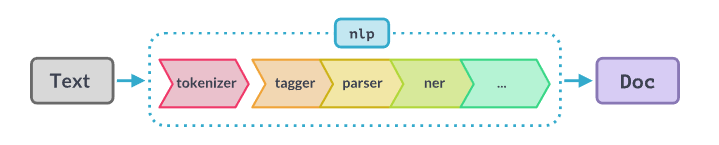

In [ ]:
nlp = en_core_web_sm.load()

text_processing = TextProcessing()

def clean_text_column(text):
    # Suppression des préfixes de langue
    text = re.sub(r'\b\w{2}:\b', ' ', text)  # \b délimite le mot et \w{2} correspond à deux lettres
    # Remplacement des tirets par des espaces
    text = text.replace('-', ' ')
    # Suppression des espaces multiples
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def batch_lemmatize_text(text_series, nlp, batch_size=50):
    """
    Fonction de lemmatisation optimisée pour une série de texte.
    
    Parameters:
        text_series (pd.Series): La série de textes à traiter (ex : une colonne d'un DataFrame).
        nlp (spacy.language): Le modèle Spacy chargé pour la lemmatisation.
        batch_size (int): Le nombre de textes traités par lot (par défaut 50).
        
    Returns:
        list: Une liste de textes lemmatisés.
    """    
    # Désactivation des composants inutiles pour accélérer le traitement
    with nlp.select_pipes(disable=["ner", "parser"]):
        # Traitement par batch
        lemmatized_texts = [
            ' '.join(
                [token.lemma_ for token in doc if token.lemma_ not in STOP_WORDS]
            )
            for doc in nlp.pipe(text_series, batch_size=batch_size)
        ]
    
    return lemmatized_texts

fill_values = {
        'packaging_tags': 'en:unknown',
        'categories_tags': 'en:unknown',
        'ingredients_analysis_tags': 'unknown',
        'allergens': 'en:none',
        'traces_tags': 'en:none',
        'additives_tags': 'en:none',
        'food_groups_tags': 'en:none',
        'states_tags': 'en:unknown',
        'nutrient_levels_tags': 'en:unknown',
        'popularity_tags': 'unknown',
        'main_category': 'en:none',
        'image_url': 'en:none',
        'energy_100g': -1,
        'fat_100g': -1,
        'saturated-fat_100g': -1,
        'cholesterol_100g': -1,
        'sugars_100g': -1,
        'proteins_100g': -1,
        'salt_100g': -1,
        'fruits-vegetables-nuts-estimate-from-ingredients_100g': -1
    }

# Liste des colonnes à traiter
columns_cat = ['product_name', 'packaging_tags', 'categories_tags', 'ingredients_tags', 'ingredients_analysis_tags', 
           'nutrient_levels_tags', 'main_category', 'popularity_tags']

# Liste des colonnes où appliquer la lemmatization
columns_cat_to_lemmatize = ['packaging_tags', 'categories_tags', 'ingredients_tags', 'ingredients_analysis_tags', 
           'nutrient_levels_tags', 'main_category', 'popularity_tags']

# Liste pour stocker les noms des nouvelles colonnes créées
new_columns_cat_names = []

# Boucle pour appliquer les transformations et stocker les noms des nouvelles colonnes
for col in columns_cat:
    # Nom des nouvelles colonnes pour chaque transformation
    preprocessed_col = f'preprocessed_{col}'
    len_col = f'len_{preprocessed_col}'

    new_columns = [preprocessed_col, len_col]
    
    # Appliquer le nettoyage
    clean_data[preprocessed_col] = clean_data[col].fillna('').apply(clean_text_column)
    
    # Appliquer la standardisation
    clean_data[preprocessed_col] = clean_data[preprocessed_col].apply(text_processing.standardize)

    # Calculer la longueur des mots dans la colonne lemmatisée
    clean_data[len_col] = clean_data[preprocessed_col].apply(lambda x: len(x))
    
    # Appliquer la lemmatisation et suppression des STOP WORDS
    if (col in columns_cat_to_lemmatize):
        # Création des colonnes lemmatizées
        lemmatized_col = f'preprocessed_{col}_lemmatized'
        len_lemmatized_col = f'len_{lemmatized_col}'
        new_columns.append(lemmatized_col)
        new_columns.append(len_lemmatized_col)
        # Lematize
        clean_data[lemmatized_col] = batch_lemmatize_text(clean_data[preprocessed_col], nlp)
        # Calculer la longueur des mots dans la colonne lemmatisée
        clean_data[len_lemmatized_col] = clean_data[lemmatized_col].apply(lambda x: len(x))
    
    # Ajouter les nouveaux noms de colonnes dans la liste
    new_columns_cat_names.extend(new_columns)

# Sauvegarde du dataset pour ne pas rejouer ce script assez long
clean_data.to_csv("../data/processed/clean_dataset.csv")
# Affichage des noms des nouvelles colonnes créées
print("Noms des nouvelles colonnes créées :")
print(new_columns_cat_names)
# Affichage des premières lignes des nouvelles colonnes
clean_data[new_columns_cat_names].head()

Noms des nouvelles colonnes créées :
['preprocessed_product_name', 'len_preprocessed_product_name', 'preprocessed_packaging_tags', 'len_preprocessed_packaging_tags', 'preprocessed_packaging_tags_lemmatized', 'len_preprocessed_packaging_tags_lemmatized', 'preprocessed_categories_tags', 'len_preprocessed_categories_tags', 'preprocessed_categories_tags_lemmatized', 'len_preprocessed_categories_tags_lemmatized', 'preprocessed_ingredients_tags', 'len_preprocessed_ingredients_tags', 'preprocessed_ingredients_tags_lemmatized', 'len_preprocessed_ingredients_tags_lemmatized', 'preprocessed_ingredients_analysis_tags', 'len_preprocessed_ingredients_analysis_tags', 'preprocessed_ingredients_analysis_tags_lemmatized', 'len_preprocessed_ingredients_analysis_tags_lemmatized', 'preprocessed_nutrient_levels_tags', 'len_preprocessed_nutrient_levels_tags', 'preprocessed_nutrient_levels_tags_lemmatized', 'len_preprocessed_nutrient_levels_tags_lemmatized', 'preprocessed_main_category', 'len_preprocessed_ma

,preprocessed_product_name,len_preprocessed_product_name,preprocessed_packaging_tags,len_preprocessed_packaging_tags,preprocessed_packaging_tags_lemmatized,len_preprocessed_packaging_tags_lemmatized,preprocessed_categories_tags,len_preprocessed_categories_tags,preprocessed_categories_tags_lemmatized,len_preprocessed_categories_tags_lemmatized,preprocessed_ingredients_tags,len_preprocessed_ingredients_tags,preprocessed_ingredients_tags_lemmatized,len_preprocessed_ingredients_tags_lemmatized,preprocessed_ingredients_analysis_tags,len_preprocessed_ingredients_analysis_tags,preprocessed_ingredients_analysis_tags_lemmatized,len_preprocessed_ingredients_analysis_tags_lemmatized,preprocessed_nutrient_levels_tags,len_preprocessed_nutrient_levels_tags,preprocessed_nutrient_levels_tags_lemmatized,len_preprocessed_nutrient_levels_tags_lemmatized,preprocessed_main_category,len_preprocessed_main_category,preprocessed_main_category_lemmatized,len_preprocessed_main_category_lemmatized,preprocessed_popularity_tags,len_preprocessed_popularity_tags,preprocessed_popularity_tags_lemmatized,len_preprocessed_popularity_tags_lemmatized
4,bio inulin,10,glass,5,glass,5,plant based foods and beverages plant based fo...,117,plant base food beverage plant base food fruit...,96,apricot juice and puree fruit prunus species f...,123,apricot juice puree fruit prunus specie fruit ...,116,palm oil free vegan vegetarian,30,palm oil free vegan vegetarian,30,fat in low quantity saturated fat in low quant...,98,fat low quantity saturate fat low quantity sug...,84,vegetables,10,vegetable,9,unknown,7,unknown,7
9,madeleines nature,17,plastic cardboard boite en carton film en plas...,51,plastic cardboard boite en carton film en plas...,51,snacks desserts sweet snacks biscuits and cake...,81,snack dessert sweet snack biscuit cake cake ma...,69,wheat flour cereal flour wheat cereal flour su...,435,wheat flour cereal flour wheat cereal flour su...,417,palm oil free non vegan vegetarian status unknown,49,palm oil free non vegan vegetarian status unknown,49,fat in high quantity saturated fat in moderate...,105,fat high quantity saturate fat moderate quanti...,91,plain madeleines,16,plain madeleine,15,top 50000 scans 2019top 100000 scans 2019at le...,1572,50000 scan 2019top 100000 scan 2019at 5 scan 2...,1375
14,madeleines chocolait,20,plastic cardboard,17,plastic cardboard,17,snacks sweet snacks biscuits and cakes cakes c...,92,snack sweet snack biscuit cake cake chocolate ...,80,wheat flour cereal flour wheat cereal flour mi...,564,wheat flour cereal flour wheat cereal flour mi...,531,palm oil free non vegan maybe vegetarian,40,palm oil free non vegan maybe vegetarian,40,fat in high quantity saturated fat in high qua...,101,fat high quantity saturate fat high quantity s...,87,chocolate madeleines,20,chocolate madeleine,19,top 50000 scans 2019top 100000 scans 2019at le...,1641,50000 scan 2019top 100000 scan 2019at 5 scan 2...,1447
18,madeleines choco noir,21,1 boite en carton a recycler 50 sachets indivi...,62,1 boite en carton recycler 50 sachet individue...,56,snacks sweet snacks biscuits and cakes cakes c...,92,snack sweet snack biscuit cake cake chocolate ...,80,wheat flour cereal flour wheat cereal flour da...,557,wheat flour cereal flour wheat cereal flour da...,530,palm oil free non vegan vegetarian status unknown,49,palm oil free non vegan vegetarian status unknown,49,fat in high quantity saturated fat in high qua...,101,fat high quantity saturate fat high quantity s...,87,chocolate madeleines,20,chocolate madeleine,19,top 50000 scans 2019top 100000 scans 2019at le...,1571,50000 scan 2019top 100000 scan 2019at 5 scan 2...,1386
20,farandole de madeleine,22,boite en carton film en plastique,33,boite en carton film en plastique,33,snacks sweet snacks biscuits and cakes cakes c...,108,snack sweet snack biscuit cake cake chocolate ...,95,madeleines choconoir madeleines nappees de cho...,951,madeleines choconoir madeleine nappees de choc...,916,palm oil content unknown n

## Training

Essai avec un entrainement d'un modèle simple Kmeans.

Rappel :

**1. CountVectorizer**

- **Principe :** Compte le nombre d’occurrences de chaque mot dans un texte ou une liste de tags.
- **Utilisation :** Représente chaque mot par une colonne dans une matrice, avec une valeur représentant sa fréquence.
- **Avantage :** Simple et rapide à calculer, utile pour des listes ou textes courts où la présence des mots est suffisante.
- **Limite :** Ne capture pas les relations sémantiques (ex. "sucre" ≠ "glucose").

**2. TF-IDF Vectorizer**

- **Principe :** Calcule la fréquence des mots ajustée par leur rareté dans l’ensemble des documents.
- **Utilisation :** Les mots fréquents dans peu de documents reçoivent une valeur plus élevée, permettant de distinguer des termes spécifiques.
- **Avantage :** Diminue l’importance des mots très fréquents (ex. "de", "le") et met en avant les mots distinctifs.
- **Limite :** Ne capture pas la similarité sémantique entre les mots.

**3. Word Embeddings (Word2Vec, GloVe)**

- **Principe :** Apprend à représenter chaque mot dans un espace vectoriel de manière à ce que des mots contextuellement proches soient également proches dans l’espace vectoriel.
- **Utilisation :** Représente chaque mot par un vecteur de plusieurs dimensions, capturant des relations sémantiques (ex. "roi" proche de "reine").
- **Avantage :** Capture les similarités et relations entre mots, utile pour les tâches nécessitant une compréhension sémantique.
- **Limite :** Ne prend pas en compte le contexte spécifique d'une phrase.

**4. FastText**

- **Principe :** Apprend également des embeddings mais utilise des sous-mots (n-grammes de caractères), ce qui permet de mieux comprendre les mots avec des similitudes orthographiques.
- **Exemple :** FastText repère des similarités entre "glucose" et "sucre" en utilisant des sous-parties communes dans les mots. Si des variantes de mots sont dans le dataset (ex. "sucreries", "sucre"), FastText peut capturer ces relations plus finement.
- **Avantage :** Idéal pour des données contenant des variantes ou des erreurs typographiques, tout en offrant des similarités proches de Word2Vec et BERT pour les termes proches.
- **Limite :** FastText est limité par son incapacité à capter le contexte global, la syntaxe et la structure grammaticale, ce qui le rend moins performant pour comprendre le sens des mots dans des phrases complexes ou ambiguës

**5. BERT (Contextual Embeddings)**

- **Principe :** Génère des représentations contextuelles pour chaque mot dans une phrase, tenant compte du contexte global.
- **Utilisation :** Représente chaque mot différemment selon le contexte de la phrase (ex. "batterie" dans "batterie de cuisine" vs. "batterie de voiture").
- **Avantage :** Idéal pour les phrases et textes complexes nécessitant une compréhension fine du contexte.
- **Limite :** Modèle très coûteux en calcul, moins utile pour des listes simples de mots isolés.

--- 

**En résumé :**

CountVectorizer et TF-IDF sont légers et efficaces pour des listes de tags ou des mots courts.

Word Embeddings ajoutent la dimension sémantique.

BERT excelle dans des phrases contextuelles, mais est plus lourd et parfois excessif pour des mots isolés.

In [ ]:
# Chargement de clean dataset
clean_data = pd.read_csv("../data/processed/clean_dataset.csv", index_col=0)

/tmp/ipykernel_417130/74601419.py:2: DtypeWarning:

Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.



In [ ]:
def get_unique_word_counts(df, columns):
    """
    Récupérer le nombre de mots pour une liste de features
    """
    word_counts = {}

    for col in columns:
        # Fusionner tous les textes en un seul pour chaque colonne
        all_text = df[col].fillna('').str.cat(sep=' ')
        
        # Vectorisation pour obtenir le vocabulaire de la colonne
        vectorizer = CountVectorizer()
        vectorizer.fit([all_text])
        
        # Récupération du nombre de mots uniques pour la colonne
        unique_word_count = len(vectorizer.get_feature_names_out())
        word_counts[col] = unique_word_count

    # Transformer les résultats en DataFrame
    word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['Unique Word Count'])
    word_counts_df.index.name = 'Column'
    
    return word_counts_df

categorial_columns = [
    'preprocessed_product_name', 'preprocessed_packaging_tags_lemmatized', 'preprocessed_categories_tags_lemmatized', 
    'preprocessed_ingredients_tags_lemmatized', 'preprocessed_ingredients_analysis_tags_lemmatized', 
    'preprocessed_main_category_lemmatized'
]
word_counts_df = get_unique_word_counts(clean_data, categorial_columns)
display(word_counts_df)


,Unique Word Count
Column,
preprocessed_product_name,43893
preprocessed_packaging_tags_lemmatized,3682
preprocessed_categories_tags_lemmatized,7010
preprocessed_ingredients_tags_lemmatized,183395
preprocessed_ingredients_analysis_tags_lemmatized,11
preprocessed_main_category_lemmatized,6188


In [ ]:
clean_data['preprocessed_packaging_tags_lemmatized'].head()

4                                                 glass
9     plastic cardboard boite en carton film en plas...
14                                    plastic cardboard
18    1 boite en carton recycler 50 sachet individue...
20                    boite en carton film en plastique
Name: preprocessed_packaging_tags_lemmatized, dtype: object

In [ ]:
clean_data.nutriscore_grade.value_counts()

nutriscore_grade
unknown           54358
d                 54093
c                 40466
a                 34191
e                 33790
b                 27259
not-applicable    10608
Name: count, dtype: int64

In [ ]:
clean_data.ecoscore_grade.value_counts()

ecoscore_grade
unknown           92175
b                 31523
c                 27798
d                 26295
a                 22594
e                 20675
a-plus            19124
f                 10479
not-applicable     4102
Name: count, dtype: int64

In [ ]:
clean_data.head()

,code,url,product_name,packaging_tags,categories_tags,ingredients_tags,ingredients_analysis_tags,allergens,traces_tags,additives_tags,nutriscore_grade,food_groups_tags,states_tags,ecoscore_grade,nutrient_levels_tags,popularity_tags,main_category,image_url,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,sugars_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,last_modified_year,preprocessed_nutriscore_grade,preprocessed_ecoscore_grade,preprocessed_product_name,len_preprocessed_product_name,preprocessed_packaging_tags,len_preprocessed_packaging_tags,preprocessed_packaging_tags_lemmatized,len_preprocessed_packaging_tags_lemmatized,preprocessed_categories_tags,len_preprocessed_categories_tags,preprocessed_categories_tags_lemmatized,len_preprocessed_categories_tags_lemmatized,preprocessed_ingredients_tags,len_preprocessed_ingredients_tags,preprocessed_ingredients_tags_lemmatized,len_preprocessed_ingredients_tags_lemmatized,preprocessed_ingredients_analysis_tags,len_preprocessed_ingredients_analysis_tags,preprocessed_ingredients_analysis_tags_lemmatized,len_preprocessed_ingredients_analysis_tags_lemmatized,preprocessed_nutrient_levels_tags,len_preprocessed_nutrient_levels_tags,preprocessed_nutrient_levels_tags_lemmatized,len_preprocessed_nutrient_levels_tags_lemmatized,preprocessed_main_category,len_preprocessed_main_category,preprocessed_main_category_lemmatized,len_preprocessed_main_category_lemmatized,preprocessed_popularity_tags,len_preprocessed_popularity_tags,preprocessed_popularity_tags_lemmatized,len_preprocessed_popularity_tags_lemmatized
4,5,http://world-en.openfoodfacts.org/product/0000...,Bio inulin,en:glass,"en:plant-based-foods-and-beverages,en:plant-ba...","en:apricot-juice-and-puree,en:fruit,en:prunus-...","en:palm-oil-free,en:vegan,en:vegetarian",en:none,en:none,en:none,a,"en:fruits-and-vegetables,en:vegetables","en:to-be-completed,en:nutrition-facts-complete...",unknown,"en:fat-in-low-quantity,en:saturated-fat-in-low...",unknown,en:vegetables,https://images.openfoodfacts.org/images/produc...,840.0,0.0,0.0,-1.0,8.0,0.0,0.23,50.000000,2024,1,0,bio inulin,10,glass,5,glass,5,plant based foods and beverages plant based fo...,117,plant base food beverage plant base food fruit...,96,apricot juice and puree fruit prunus species f...,123,apricot juice puree fruit prunus specie fruit ...,116,palm oil free vegan vegetarian,30,palm oil free vegan vegetarian,30,fat in low quantity saturated fat in low quant...,98,fat low quantity saturate fat low quantity sug...,84,vegetables,10,vegetable,9,unknown,7,unknown,7
9,10,http://world-en.openfoodfacts.org/product/0000...,Madeleines nature,"en:plastic,en:cardboard,fr:boite-en-carton,fr:...","en:snacks,en:desserts,en:sweet-snacks,en:biscu...","en:wheat-flour,en:cereal,en:flour,en:wheat,en:...","en:palm-oil-free,en:non-vegan,en:vegetarian-st...",other,other,"en:e331,en:e422,en:e503",d,"en:sugary-snacks,en:biscuits-and-cakes","en:to-be-completed,en:nutrition-facts-complete...",c,"en:fat-in-high-quantity,en:saturated-fat-in-mo...","top-50000-scans-2019,top-100000-scans-2019,at-...",en:plain-madeleines,https://images.openfoodfacts.org/images/produc...,1852.0,22.0,2.6,-1.0,25.0,6.4,0.53,22.666667,2024,4,4,madeleines nature,17,plastic cardboard boite en carton film en plas...,51,plastic cardboard boite en carton film en plas...,51,snacks desserts sweet snacks biscuits and cake...,81,snack dessert sweet snack biscuit cake cake ma...,69,wheat flour cereal flour wheat cereal flour su...,435,wheat flour cereal flour wheat cereal flour su...,417,palm oil free non vegan vegetarian status unknown,49,palm oil free non vegan vegetarian status unknown,49,fat in high quantity saturated fat in moderate...,105,fat high quantity saturate fat moderate quanti...,91,plain madeleines,16,plain madeleine,15,top 50000 scans 2019top 100000 scans 2019at le...,1572,50000 scan 2019top 100000 scan 2019at 5 scan 2...,1375
14,15,http://world-en.openfoodfacts.org/product/0000...,

### Preprocessing

In [ ]:
# Colonnes numériques et catégorielles
numeric_columns = [
    'energy_100g', 'fat_100g', 'saturated-fat_100g', 'cholesterol_100g', 
    'sugars_100g', 'proteins_100g', 'salt_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g',
    'preprocessed_nutriscore_grade', 'preprocessed_ecoscore_grade'
]
categorial_columns = [
    'preprocessed_product_name', 'preprocessed_packaging_tags_lemmatized', 'preprocessed_categories_tags_lemmatized', 
    'preprocessed_ingredients_tags_lemmatized', 'preprocessed_ingredients_analysis_tags_lemmatized', 
    'preprocessed_main_category_lemmatized'
]

# Fonction d'imputation pour les valeurs numériques
def impute_numeric_data(df, columns):
    imputer = SimpleImputer(strategy='mean')
    df[columns] = imputer.fit_transform(df[columns])
    return df

# Fonction de normalisation des colonnes numériques
def scale_numeric_data(df, columns):
    scaler = StandardScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df

# Fonction de transformation de texte pour les colonnes catégorielles
def encode_categorical_data_with_svd(df, columns, max_features=500, min_df=4, n_components=50):
    print('encode_categorical_data_with_svd')
    vectorizer = CountVectorizer(max_features=max_features, min_df=min_df)
    encoded_columns = []
    
    for col in columns:
        print('column', col)
        # Encodage du texte
        encoded = vectorizer.fit_transform(df[col].fillna(''))
        print('encoded.shape', encoded.shape[1])
        
        # Ajustement de n_components pour TruncatedSVD si nécessaire
        adjusted_n_components = min(n_components, encoded.shape[1])
        print('adjusted_n_components:', adjusted_n_components)
        # Réduction de dimensions avec TruncatedSVD plus optimisé avec les sparses matrices que PCA
        svd = TruncatedSVD(n_components=adjusted_n_components, random_state=42)
        
        # Réduction de dimensions
        reduced = svd.fit_transform(encoded)
        encoded_columns.append(pd.DataFrame(reduced))
    
    vectorizer_nb_features = vectorizer.get_feature_names_out()
    print("[INFO][CountVectorizer] : Nombre de features dans le vocabulaire : ", len(vectorizer_nb_features))
    return pd.concat(encoded_columns, axis=1)

# Fonction de transformation de texte pour les colonnes catégorielles avec PCA
def encode_categorical_data_with_pca(df, columns, max_features=500, min_df=4, n_components=50):
    print('encode_categorical_data_with_pca')
    vectorizer = CountVectorizer(max_features=max_features, min_df=min_df)
    encoded_columns = []
    
    for col in columns:
        print('column', col)
        # Encodage du texte
        encoded = vectorizer.fit_transform(df[col].fillna(''))
        print('encoded.shape', encoded.shape[1])
        
        # Conversion en matrice dense
        dense_encoded = encoded.toarray()  
        
        # Ajustement de n_components pour PCA si nécessaire
        adjusted_n_components = min(n_components, dense_encoded.shape[1])
        print('adjusted_n_components:', adjusted_n_components)
        
        # Réduction de dimensions avec PCA
        pca = PCA(n_components=adjusted_n_components, random_state=42)
        
        # Réduction de dimensions
        reduced = pca.fit_transform(dense_encoded)
        encoded_columns.append(pd.DataFrame(reduced))
    
    vectorizer_nb_features = vectorizer.get_feature_names_out()
    print("[INFO][CountVectorizer] : Nombre de features dans le vocabulaire : ", len(vectorizer_nb_features))
    return pd.concat(encoded_columns, axis=1)


# Fonction de clustering et calcul des scores
def cluster_data(features, cluster_range, random_state=42):
    silhouette_scores = []
    inertia = []
    
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(features)
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(features, labels))
    
    return labels, silhouette_scores, inertia

# Fonction principale de préparation des données et de clustering
def find_optimal_clusters(df, cluster_range, encoding_method=encode_categorical_data_with_svd, random_state=42):
    # Imputation des valeurs numériques
    df = impute_numeric_data(df, numeric_columns)
    
    # Encodage des données catégorielles
    categorical_features = encoding_method(df, categorial_columns)
    
    # Normalisation des données numériques
    df = scale_numeric_data(df, numeric_columns)
    
    # Assemblage des features
    features = pd.concat([categorical_features, df[numeric_columns].reset_index(drop=True)], axis=1)
    features.columns = features.columns.astype(str)
    
    # Clustering et calcul des scores
    labels, silhouette_scores, inertia = cluster_data(features, cluster_range=cluster_range, random_state=random_state)
    
    # Ajout des labels de clusters au DataFrame
    df['cluster'] = labels
    return labels, silhouette_scores, inertia

def train_kmeans_with_manual_clusters(df, n_clusters, encoding_method=encode_categorical_data_with_svd, random_state=42):
    """
    Applique un KMeans avec un nombre de clusters spécifié manuellement.
    
    Parameters:
        df (DataFrame): Le DataFrame contenant les données sur lesquelles appliquer le KMeans.
        n_clusters (int): Le nombre de clusters à utiliser.
        random_state (int): L'état aléatoire pour assurer la reproductibilité.
    
    Returns:
        DataFrame: Le DataFrame avec les labels de clusters ajoutés.
    """
    # Imputation des valeurs numériques
    df = impute_numeric_data(df, numeric_columns)
    
    # Encodage des données catégorielles
    categorical_features = encoding_method(df, categorial_columns)
    
    # Normalisation des données numériques
    df = scale_numeric_data(df, numeric_columns)
    
    # Assemblage des features
    features = pd.concat([categorical_features, df[numeric_columns].reset_index(drop=True)], axis=1)
    features.columns = features.columns.astype(str)
    print(f'feature list for kmeans prediction : {features}')
    
    # Apprentissage du modèle KMeans avec le nombre de clusters spécifié
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    df['cluster'] = kmeans.fit_predict(features)
    
    return df

def train_dbscan_with_encoding(df, encoding_method, eps=0.5, min_samples=5, metric='euclidean'):
    """
    Applique le clustering DBSCAN sur les données après encodage des données catégorielles et normalisation.
    
    Parameters:
        df (DataFrame): Le DataFrame contenant les données sur lesquelles appliquer DBSCAN.
        encoding_method (function): La fonction d'encodage pour les colonnes catégorielles.
        eps (float): La distance maximale pour deux points d'être considérés comme voisins.
        min_samples (int): Le nombre minimum de points pour former un cluster.
    
    Returns:
        DataFrame: Le DataFrame avec les labels de clusters ajoutés.
    """
    # Imputation des valeurs numériques
    df = impute_numeric_data(df, numeric_columns)
    
    # Encodage des données catégorielles
    categorical_features = encoding_method(df, categorial_columns)
    
    # Normalisation des données numériques
    df = scale_numeric_data(df, numeric_columns)
    
    # Assemblage des features
    features = pd.concat([categorical_features, df[numeric_columns].reset_index(drop=True)], axis=1)
    features.columns = features.columns.astype(str)
    
    # Apprentissage du modèle DBSCAN avec les paramètres spécifiés
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
    df['cluster'] = dbscan.fit_predict(features)
    
    return df

def inertia_elbow_plotly(cluster_range, inertia, silhouette_scores):
    data = pd.DataFrame({
        'Number of clusters': cluster_range,
        'Inertia': inertia,
        'Silhouette Score': silhouette_scores
    })
    
    # Graphique Elbow (Inertia)
    fig_inertia = px.line(
        data,
        x='Number of clusters',
        y='Inertia',
        markers=True,
        title="Elbow Method"
    )
    fig_inertia.update_layout(
        xaxis_title="Number of clusters",
        yaxis_title="Inertia"
    )
    
    # Graphique Silhouette
    fig_silhouette = px.line(
        data,
        x='Number of clusters',
        y='Silhouette Score',
        markers=True,
        title="Silhouette Score"
    )
    fig_silhouette.update_layout(
        xaxis_title="Number of clusters",
        yaxis_title="Silhouette Score"
    )
    
    fig_inertia.show()
    fig_silhouette.show()


cluster_range=range(50, 1000, 25)

labels_svd, silhouette_scores_svd, inertia_svd = find_optimal_clusters(df=clean_data.sample(5000, random_state=42), 
                                                                             cluster_range=cluster_range,
                                                                             encoding_method=encode_categorical_data_with_svd)

# Utilisation de la nouvelle fonction dans l'entraînement KMeans
labels_pca, silhouette_scores_pca, inertia_pca = find_optimal_clusters(df=clean_data.sample(5000, random_state=42), 
                                                                             cluster_range=cluster_range,
                                                                             encoding_method=encode_categorical_data_with_pca)

encode_categorical_data_with_svd
column preprocessed_product_name
encoded.shape 500
adjusted_n_components: 50
column preprocessed_packaging_tags_lemmatized
encoded.shape 106
adjusted_n_components: 50
column preprocessed_categories_tags_lemmatized
encoded.shape 500
adjusted_n_components: 50
column preprocessed_ingredients_tags_lemmatized
encoded.shape 500
adjusted_n_components: 50
column preprocessed_ingredients_analysis_tags_lemmatized
encoded.shape 11
adjusted_n_components: 11
column preprocessed_main_category_lemmatized
encoded.shape 482
adjusted_n_components: 50
[INFO][CountVectorizer] : Nombre de features dans le vocabulaire :  482
encode_categorical_data_with_pca
column preprocessed_product_name
encoded.shape 500
adjusted_n_components: 50
column preprocessed_packaging_tags_lemmatized
encoded.shape 106
adjusted_n_components: 50
column preprocessed_categories_tags_lemmatized
encoded.shape 500
adjusted_n_components: 50
column preprocessed_ingredients_tags_lemmatized
encoded.shape 500

In [ ]:
# Affichage des résultats TruncatedSVD
print(labels_svd[:5], len(labels_svd))
print("Silhouette Scores:", silhouette_scores_svd)
print("Inertia:", inertia_svd)

inertia_elbow_plotly(cluster_range=cluster_range, inertia=inertia_svd, silhouette_scores=silhouette_scores_svd)

[118 210   6 225  56] 5000
Silhouette Scores: [0.10098658395680099, 0.10322685981700287, 0.0986998537389983, 0.09870711515046693, 0.09555627250766478, 0.09272075003233592, 0.09236837525361591, 0.09197981037873963, 0.09387490760905413, 0.0967587239484476, 0.0910003197783504, 0.09372304345189919, 0.09516626339430939, 0.09624530277688398, 0.09414110735253825, 0.09806450377211594, 0.09708416189403354, 0.09699519819701309, 0.09393486043136279, 0.09408153230276109, 0.0932599272079686, 0.09188654347706238, 0.09061126367781133, 0.09217439060689847, 0.09242584670989905, 0.09376205969488896, 0.09342066732523305, 0.09505532588429609, 0.09636129372160959, 0.09715095044361921, 0.09652449615057707, 0.09724659305720208, 0.09851917270639371, 0.0973334948183592, 0.09744435291061088, 0.09699543365248217, 0.09660247085234745, 0.0978334257496437]
Inertia: [196540.70555422106, 177509.8696401618, 166654.44520522587, 157703.76880026306, 151629.9395861803, 145798.222513613, 140751.1376565001, 136384.330405026

In [ ]:
# Affichage des résultats PCA
print(labels_pca[:5], len(labels_pca))
print("Silhouette Scores:", silhouette_scores_pca)
print("Inertia:", inertia_pca)

inertia_elbow_plotly(cluster_range=cluster_range, inertia=inertia_pca, silhouette_scores=silhouette_scores_pca)

[326 120  21 597 948] 5000
Silhouette Scores: [0.09769137842707293, 0.10067646079503782, 0.09832832839142938, 0.09359890230510855, 0.09769338173890812, 0.0972234168073013, 0.09502746022088286, 0.09712490375846633, 0.09902364808427155, 0.09945214330510373, 0.09775066714597928, 0.097623238358911, 0.09834448242856322, 0.0987971914276119, 0.0979907749307666, 0.09070923811484767, 0.0928962205262097, 0.09327940616549481, 0.09461516195591867, 0.0951486241008648, 0.09379013485877151, 0.09261543354146252, 0.09256206872823479, 0.09162681773078776, 0.09154520420934646, 0.09239779848374084, 0.09120877952419593, 0.09197351518640136, 0.09467636677115385, 0.094023897314899, 0.09459506130622529, 0.09488674983215727, 0.09481100840062397, 0.09550599656068882, 0.09719050810531064, 0.09776338213993675, 0.09696869637375062, 0.09697759108027929]
Inertia: [196741.99205703987, 179468.2272001044, 167336.3054199401, 158292.30555420637, 152307.23849301483, 146761.20731522102, 141571.19392454124, 136706.946708772

In [ ]:
# Sauvegarde du dataset utilisé pour les entrainements (à utiliser pour kmean ou autre directement, pas pour train_kmeans_with_manual_clusters)
selected_columns = categorial_columns + numeric_columns
clean_dataset_preprocessed = clean_data[selected_columns]
print(clean_dataset_preprocessed.shape)
clean_dataset_preprocessed.to_csv("../data/processed/clean_dataset_preprocessed.csv")
clean_dataset_preprocessed.head()

(254765, 16)


,preprocessed_product_name,preprocessed_packaging_tags_lemmatized,preprocessed_categories_tags_lemmatized,preprocessed_ingredients_tags_lemmatized,preprocessed_ingredients_analysis_tags_lemmatized,preprocessed_main_category_lemmatized,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,sugars_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,preprocessed_nutriscore_grade,preprocessed_ecoscore_grade
4,bio inulin,glass,plant base food beverage plant base food fruit...,apricot juice puree fruit prunus specie fruit ...,palm oil free vegan vegetarian,vegetable,840.0,0.0,0.0,-1.0,8.0,0.0,0.23,50.000000,1,0
9,madeleines nature,plastic cardboard boite en carton film en plas...,snack dessert sweet snack biscuit cake cake ma...,wheat flour cereal flour wheat cereal flour su...,palm oil free non vegan vegetarian status unknown,plain madeleine,1852.0,22.0,2.6,-1.0,25.0,6.4,0.53,22.666667,4,4
14,madeleines chocolait,plastic cardboard,snack sweet snack biscuit cake cake chocolate ...,wheat flour cereal flour wheat cereal flour mi...,palm oil free non vegan maybe vegetarian,chocolate madeleine,1926.0,24.0,6.0,-1.0,31.0,6.4,0.48,16.250000,4,5
18,madeleines choco noir,1 boite en carton recycler 50 sachet individue...,snack sweet snack biscuit cake cake chocolate ...,wheat flour cereal flour wheat cereal flour da...,palm oil free non vegan vegetarian status unknown,chocolate madeleine,1953.0,25.0,6.1,-1.0,29.0,6.3,0.45,16.250000,4,5
20,farandole de madeleine,boite en carton film en plastique,snack sweet snack biscuit cake cake chocolate ...,madeleines choconoir madeleine nappees de choc...,palm oil content unknown non vegan vegetarian ...,long madeleine,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,1.750000,0,5


In [ ]:
# Appliquer KMeans avec le meilleur nombre de clusters
df_result_svd = train_kmeans_with_manual_clusters(df=clean_data, n_clusters=525, encoding_method=encode_categorical_data_with_svd)

encode_categorical_data_with_svd
column preprocessed_product_name
encoded.shape 500
adjusted_n_components: 50
column preprocessed_packaging_tags_lemmatized
encoded.shape 500
adjusted_n_components: 50
column preprocessed_categories_tags_lemmatized
encoded.shape 500
adjusted_n_components: 50
column preprocessed_ingredients_tags_lemmatized
encoded.shape 500
adjusted_n_components: 50
column preprocessed_ingredients_analysis_tags_lemmatized
encoded.shape 11
adjusted_n_components: 11
column preprocessed_main_category_lemmatized
encoded.shape 500
adjusted_n_components: 50
[INFO][CountVectorizer] : Nombre de features dans le vocabulaire :  500
feature list for kmeans prediction :                0         1         2         3         4         5         6  \
0       0.050087  0.057795  0.361538  0.855646 -0.300645 -0.094939  0.018655   
1       0.013115  0.020698  0.010347  0.033833 -0.023535  0.005437  0.020294   
2       0.001393  0.003630  0.003631  0.002216  0.006946  0.001548  0.007554   

In [ ]:
df_result_pca = train_kmeans_with_manual_clusters(df=clean_data, n_clusters=525, encoding_method=encode_categorical_data_with_pca)

encode_categorical_data_with_pca
column preprocessed_product_name
encoded.shape 500
adjusted_n_components: 50
column preprocessed_packaging_tags_lemmatized
encoded.shape 500
adjusted_n_components: 50
column preprocessed_categories_tags_lemmatized
encoded.shape 500
adjusted_n_components: 50
column preprocessed_ingredients_tags_lemmatized
encoded.shape 500
adjusted_n_components: 50
column preprocessed_ingredients_analysis_tags_lemmatized
encoded.shape 11
adjusted_n_components: 11
column preprocessed_main_category_lemmatized
encoded.shape 500
adjusted_n_components: 50
[INFO][CountVectorizer] : Nombre de features dans le vocabulaire :  500
feature list for kmeans prediction :                0         1         2         3         4         5         6  \
0      -0.288607 -0.100793 -0.036611  0.838473 -0.407470  0.104317  0.071578   
1      -0.295401 -0.084978 -0.070905 -0.033997 -0.012080 -0.043770 -0.013733   
2      -0.290489 -0.086684 -0.047931 -0.042914  0.017310 -0.038043 -0.016123   

In [ ]:
df_result_svd.shape

(254765, 60)

In [ ]:
sample_df = df_result_svd.sample(1000)
sample_df.to_csv("../data/processed/sample_svd.csv")

In [ ]:
cluster_count_df =df_result_svd["cluster"].value_counts().reset_index()
cluster_count_df

,cluster,count
0,30,5844
1,37,2737
2,1,1953
3,83,1812
4,514,1777
...,...,...
520,86,2
521,16,2
522,19,1
523,21,1


In [ ]:
cluster_count_df[cluster_count_df["count"] > 10]

,cluster,count
0,30,5844
1,37,2737
2,1,1953
3,83,1812
4,514,1777
...,...,...
512,493,67
513,489,60
514,403,33
515,69,32


In [ ]:
df_result_svd["cluster"].value_counts()


df_result_svd[["product_name"]][df_result_svd["cluster"] == 55].head(20)

,product_name
24987,"Sauté de porc à la moutarde, farfalles, carottes"
64353,Thaï Massaman Curry
77958,Chunky Blue Cheese
78082,Kraft Italian five cheese
78593,Classic ranch dressing
99647,Tofurky 10% Off Slow Roasted Chick'n Lightly S...
274160,Ondulées crème sure et oignon
288931,California roll selection
317938,Classic Ranch
350043,Herr’s Honey Cheese


In [ ]:
df_result_pca["cluster"].value_counts()


df_result_pca[["product_name"]][df_result_pca["cluster"] == 100].head(20)

,product_name
47141,Freshly Squeezed Still Lemonade
68157,Spritz
72772,Boisson à base d annanas
203394,Eau Gazéifiée (aranciata Rossa)
203427,Sanpellecrino Orange
268228,"Iced tea Cherry, Blackcurrant & Earl Grey"
268457,British rhubarb & vanilla juice
397168,Boisson à L'orange Splash
410532,Island wave limonade
410536,Calypso


In [ ]:
df_result_svd[["product_name"]][df_result_svd["cluster"] == 20].head(20)

,product_name
8970,Bircher style muesli
10031,Porridge de Riz
26857,Yellow Corn meal
63617,Frosted toasted oat cereal with marshmallows
77517,porridge protéiné
98901,Nutty Porridge
100265,Rice Cake SS Sel
106583,Vegetable Lasagne
124093,Oat and barley porridge
243853,Steel Cut Organic Oats


In [ ]:
df_result_svd[["product_name"]][df_result_svd["cluster"] == 169].head(20)

,product_name
159611,Fruits et graines muesli
159723,Muesli
166643,Granola sans gluten Muesli fruits secs et sarr...
285836,Muesli aux Fruits
294015,Céréale Mini-wheats (framboise)
297989,Céréales Cheerios (pommes & Cannelle)
417133,"Granola, Berry & Orange"
446536,Muesli
452674,Summer berry compote
593250,Muesli Fruits


In [ ]:
df_result_svd[["product_name"]][df_result_svd["cluster"] == 489].head(20)

,product_name
1054252,Deluxe Mini bouchées
1055604,12 mini croustillants colorés
1215777,Pain Surprise aux céréales surgelé
1342773,Ma Tartine Jambon et Mozzarella
1342797,"Mon croque jambon, chorizo"
1354573,Petits fours apéritifs
1356154,20 Mini Canapés
1357897,40 mini feuilletés apéritifs
1357936,Pain surprise étoile
1368923,20 Canapés traiteur


In [ ]:
df_result_pca[["product_name"]][df_result_pca["cluster"] == 165].head(20)

,product_name
493814,Concassé de tomates mi-séchées
996881,Poêlée de gambas et tagliatelles sauc crustacés
1002115,Bruschetta Chicken Bacon
1017671,Salade mezze
1020791,45 Mini-Apéritifs
1036384,12 Mini Aumônières
1046105,Tourte aux deux saumons
1050562,Pain Nordique Surprise
1050736,Penne poulet roti
1051268,Mezzelune Tomate & Mozzarella


In [ ]:
def plot_3d_clustering_svd(text_data, cluster_labels, product_names, main_categories, nutriscore_grades, n_components=3, height=700, width=900, sample_size=1000):
    """
    Transforme les données textuelles en vecteurs avec CountVectorizer, applique SVD pour une réduction en 3D, et visualise le clustering.
    Affiche également des informations supplémentaires dans la légende des points.

    Parameters:
        text_data (DataFrame): Les données textuelles à transformer, avec plusieurs colonnes de texte.
        cluster_labels (Series ou ndarray): Les étiquettes de clusters obtenues.
        product_names (Series): La colonne des noms de produits prétraités (lemmatisés).
        main_categories (Series): La colonne des catégories principales prétraitées (lemmatisées).
        nutriscore_grades (Series): La colonne des grades Nutri-Score.
        height (int): Hauteur du graphique.
        width (int): Largeur du graphique.
        sample_size (int): Taille de l'échantillon de données à utiliser pour la visualisation.
    """
    # Échantillonner les données si nécessaire
    sample_data = text_data.sample(n=sample_size, random_state=42)  # Random_state pour la reproductibilité
    
    # Concatenation de toutes les colonnes textuelles en une seule chaîne de texte
    combined_text = sample_data.apply(lambda x: ' '.join(x.astype(str)), axis=1)

    # Transformation des données textuelles en vecteurs avec CountVectorizer
    vectorizer = CountVectorizer()
    text_vectors = vectorizer.fit_transform(combined_text.fillna(''))

    # Appliquer SVD pour réduire en 3 dimensions
    svd = TruncatedSVD(n_components=n_components)
    reduced_features = svd.fit_transform(text_vectors)

    # Créer un DataFrame avec les nouvelles dimensions et les clusters
    df_3d = pd.DataFrame(reduced_features, columns=[f'SVD{i+1}' for i in range(n_components)])
    df_3d['Cluster'] = cluster_labels.sample(n=sample_size, random_state=42).reset_index(drop=True)
    df_3d['Product Name'] = product_names.sample(n=sample_size, random_state=42).reset_index(drop=True)
    df_3d['Main Category'] = main_categories.sample(n=sample_size, random_state=42).reset_index(drop=True)
    df_3d['Nutri-Score'] = nutriscore_grades.sample(n=sample_size, random_state=42).reset_index(drop=True)

    # Visualisation avec Plotly Express
    fig = px.scatter_3d(df_3d, x='SVD1', y='SVD2', z='SVD3', color='Cluster',
                        title="3D Visualization of Clustering with SVD",
                        labels={'SVD1': 'SVD Component 1', 
                                'SVD2': 'SVD Component 2', 
                                'SVD3': 'SVD Component 3'},
                        hover_data={'Product Name': True, 
                                    'Main Category': True, 
                                    'Nutri-Score': True})

    # Ajuster la taille du graphique
    fig.update_layout(height=height, width=width)
    
    # Afficher le graphique
    fig.show()

data_to_plot = clean_data[categorial_columns]
plot_3d_clustering_svd(clean_data[categorial_columns], clean_data['cluster'], clean_data['preprocessed_product_name'], clean_data['preprocessed_main_category_lemmatized'], clean_data['nutriscore_grade'])


In [ ]:
data_to_plot.head()

,preprocessed_product_name,preprocessed_packaging_tags_lemmatized,preprocessed_categories_tags_lemmatized,preprocessed_ingredients_tags_lemmatized,preprocessed_ingredients_analysis_tags_lemmatized,preprocessed_main_category_lemmatized
4,bio inulin,glass,plant base food beverage plant base food fruit...,apricot juice puree fruit prunus specie fruit ...,palm oil free vegan vegetarian,vegetable
9,madeleines nature,plastic cardboard boite en carton film en plas...,snack dessert sweet snack biscuit cake cake ma...,wheat flour cereal flour wheat cereal flour su...,palm oil free non vegan vegetarian status unknown,plain madeleine
14,madeleines chocolait,plastic cardboard,snack sweet snack biscuit cake cake chocolate ...,wheat flour cereal flour wheat cereal flour mi...,palm oil free non vegan maybe vegetarian,chocolate madeleine
18,madeleines choco noir,1 boite en carton recycler 50 sachet individue...,snack sweet snack biscuit cake cake chocolate ...,wheat flour cereal flour wheat cereal flour da...,palm oil free non vegan vegetarian status unknown,chocolate madeleine
20,farandole de madeleine,boite en carton film en plastique,snack sweet snack biscuit cake cake chocolate ...,madeleines choconoir madeleine nappees de choc...,palm oil content unknown non vegan vegetarian ...,long madeleine


@todo:

tester la feature selection (cf walmart project)

@todo :

tester word embeding
tester dbscan

### Word Embedding

@todo

### DBSCAN

**Choix de la valeur n_neighbors**:

- Petits datasets : commencez avec des valeurs petites de n_neighbors (5-10).
- Grands datasets : utilisez des valeurs plus élevées pour obtenir une meilleure généralisation (10-50 ou plus).
- Méthode du coude : est une méthode pratique pour identifier un bon n_neighbors.
- Validation croisée : utilisez-la pour valider la performance sur vos données.

In [ ]:

numeric_columns = [
    'energy_100g', 'fat_100g', 'saturated-fat_100g', 'cholesterol_100g', 
    'sugars_100g', 'proteins_100g', 'salt_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g',
    'preprocessed_nutriscore_grade', 'preprocessed_ecoscore_grade'
]
categorical_columns = [
    'preprocessed_product_name', 'preprocessed_packaging_tags_lemmatized', 'preprocessed_categories_tags_lemmatized', 
    'preprocessed_ingredients_tags_lemmatized', 'preprocessed_ingredients_analysis_tags_lemmatized', 
    'preprocessed_main_category_lemmatized'
]

dbscan_df = clean_data.sample(frac=0.1, random_state=42)

# Sélectionner les colonnes numériques du DataFrame et les standardiser
X_numeric = scale_numeric_data(dbscan_df[numeric_columns], numeric_columns)

# Encoder les colonnes catégorielles avec SVD
X_categorical = encode_categorical_data_with_svd(dbscan_df, categorial_columns, max_features=500, min_df=4, n_components=50)

# Combiner les caractéristiques numériques et catégorielles
X = np.hstack((X_numeric, X_categorical))

def plot_optimal_n_neighbors(X, max_neighbors=100):
    # Tableau pour stocker les distances
    distances = []

    # Essayer différentes valeurs de n_neighbors
    for n in range(1, max_neighbors + 1):
        nbrs = NearestNeighbors(n_neighbors=n, n_jobs=-1).fit(X)
        dist, _ = nbrs.kneighbors(X)
        # On prend la distance du dernier voisin (k-ième plus proche)
        distances.append(np.sort(dist[:, -1]))

    # Calculer la distance moyenne du k-ième plus proche voisin pour chaque n_neighbors
    mean_distances = [np.mean(dist) for dist in distances]

    # Créer un DataFrame pour Plotly Express
    df = pd.DataFrame({
        'n_neighbors': range(1, max_neighbors + 1),
        'mean_distance': mean_distances
    })

    # Créer le graphique avec Plotly Express
    fig = px.line(df, x='n_neighbors', y='mean_distance', title='Méthode du coude - Distances moyennes des plus proches voisins')

    # Ajouter des axes et un titre
    fig.update_layout(
        xaxis_title="Nombre de voisins (n_neighbors)",
        yaxis_title="Distance moyenne des plus proches voisins",
    )

    # Afficher le graphique
    fig.show()

# Exemple d'utilisation avec un jeu de données X
plot_optimal_n_neighbors(X, max_neighbors=30)


/tmp/ipykernel_417130/2291268932.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



encode_categorical_data_with_svd
column preprocessed_product_name
encoded.shape 500
adjusted_n_components: 50
column preprocessed_packaging_tags_lemmatized
encoded.shape 258
adjusted_n_components: 50
column preprocessed_categories_tags_lemmatized
encoded.shape 500
adjusted_n_components: 50
column preprocessed_ingredients_tags_lemmatized
encoded.shape 500
adjusted_n_components: 50
column preprocessed_ingredients_analysis_tags_lemmatized
encoded.shape 11
adjusted_n_components: 11
column preprocessed_main_category_lemmatized
encoded.shape 500
adjusted_n_components: 50
[INFO][CountVectorizer] : Nombre de features dans le vocabulaire :  500


In [ ]:

def find_optimal_eps(X, n_neighbors=10):
    # Utiliser NearestNeighbors pour trouver les distances des plus proches voisins
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1).fit(X)
    distances, indices = nbrs.kneighbors(X)
    
    # Trier les distances du k-ième plus proche voisin
    distances = np.sort(distances[:, -1])  # Tri des distances du k-ième voisin
    
    # Créer un DataFrame pour Plotly Express
    df = pd.DataFrame({
        'index': range(len(distances)),
        'distance': distances
    })
    
    # Créer le graphique avec Plotly Express
    fig = px.line(df, x='index', y='distance', title=f'k-distance Graph (n_neighbors={n_neighbors})')
    
    # Ajouter des axes et un titre
    fig.update_layout(
        xaxis_title="Index des points",
        yaxis_title="Distance au k-ième plus proche voisin",
    )
    
    # Afficher le graphique
    fig.show()

find_optimal_eps(X, n_neighbors=2)


In [ ]:
# metrics = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan'].
df_result_svd_dbscan = train_dbscan_with_encoding(
    df=clean_data.sample(frac=0.1, random_state=42),
    encoding_method=encode_categorical_data_with_svd,  # ou encode_categorical_data_with_svd
    eps=5,
    min_samples=2,
    metric='euclidean'
)
print(df_result_svd_dbscan['cluster'].value_counts())

encode_categorical_data_with_svd
column preprocessed_product_name
encoded.shape 500
adjusted_n_components: 50
column preprocessed_packaging_tags_lemmatized
encoded.shape 258
adjusted_n_components: 50
column preprocessed_categories_tags_lemmatized
encoded.shape 500
adjusted_n_components: 50
column preprocessed_ingredients_tags_lemmatized
encoded.shape 500
adjusted_n_components: 50
column preprocessed_ingredients_analysis_tags_lemmatized
encoded.shape 11
adjusted_n_components: 11
column preprocessed_main_category_lemmatized
encoded.shape 500
adjusted_n_components: 50
[INFO][CountVectorizer] : Nombre de features dans le vocabulaire :  500
cluster
 1      15899
-1       7290
 23       143
 0         94
 29        44
        ...  
 287        2
 285        2
 283        2
 281        2
 635        2
Name: count, Length: 637, dtype: int64


In [ ]:
cluster_dbscan_count_df =df_result_svd_dbscan["cluster"].value_counts().reset_index()
cluster_dbscan_count_df[cluster_dbscan_count_df["count"] > 10]

,cluster,count
0,1,15899
1,-1,7290
2,23,143
3,0,94
4,29,44
5,3,40
6,7,32
7,39,31
8,38,24
9,95,24


In [ ]:
df_result_svd_dbscan[["product_name"]][df_result_svd_dbscan["cluster"] == 0].head(20)

,product_name
1577165,La chips bio sel et vinaigre
3101870,Chips cuites au chaudron
1345267,Chips artisanales sel marin
1394125,Chips à l'ancienne nature
2328602,Sticks
1333439,Deep ridged saveur nature
1735983,La véritable Chips Légère et juste salée
1581685,Les chips de l'Aveyron
1637533,Saveur ail & olives
1577032,Chips saveur poulet braisé


### Bert

BERT signifie Bidirectional Encoder Representations from Transformers. Comme son nom l’indique ce modèle procède de façon bi-directionnel, ce qui lui permet d’avoir une bien meilleure compréhension du texte.

BERT utilise une nouvelle technique appelée Masked LM (MLM) : il masque aléatoirement des mots dans la phrase, puis il essaie de les prédire. 

Le masquage signifie que le modèle regarde dans les deux sens et qu’il utilise le contexte complet de la phrase, à gauche et à droite, afin de prédire le mot masqué.

## Recherche des produits similaires

In [ ]:
# Définir les colonnes numériques et catégorielles
NUMERIC_COLUMNS = [
    "energy_100g",
    "fat_100g",
    "saturated-fat_100g",
    "cholesterol_100g",
    "sugars_100g",
    "proteins_100g",
    "salt_100g",
    "fruits-vegetables-nuts-estimate-from-ingredients_100g",
    "preprocessed_nutriscore_grade",
    "preprocessed_ecoscore_grade",
]
CATEGORIAL_COLUMNS = [
    "product_name",
    "packaging_tags",
    "categories_tags",
    "ingredients_tags",
    "ingredients_analysis_tags",
    "main_category",
]

# Charger les données
df = pd.read_csv("../data/production/database.csv")

allergen = "en:milk"
code = 112302621

# 1. Identifier le cluster du produit de référence
product_cluster = df.loc[df["code"] == code, "cluster_text"].values[0]
target_features = df.loc[df["code"] == code, NUMERIC_COLUMNS].values

# 2. Récupérer et fusionner les colonnes catégorielles
encoded_categorical_features = pd.read_csv("../data/production/categorical_features.csv")
cluster_features_combined = pd.concat([df, encoded_categorical_features], axis=1)

# 3. Filtrer les produits du même cluster
similar_cluster_products = cluster_features_combined[cluster_features_combined["cluster_text"] == product_cluster]

# 4. Au besoin rechercher s'il y a des produits ne pouvant être présenté à cause d'allergies
if allergen:
        similar_cluster_products = similar_cluster_products[
            ~similar_cluster_products['allergens'].fillna('').str.contains(allergen, case=False) &
            ~similar_cluster_products['traces_tags'].fillna('').str.contains(allergen, case=False)
        ]


# 5. Sélectionner uniquement les colonnes numériques pour le calcul de la similarité
similar_cluster_numeric_features = similar_cluster_products[NUMERIC_COLUMNS].values

# 6. Calcul des similarités de cosinus
similarities = cosine_similarity(target_features.reshape(1, -1), similar_cluster_numeric_features).flatten()

# 7. Ajouter la similarité aux produits similaires
similar_cluster_products = similar_cluster_products.assign(similarity_text=similarities)

# 8. Trier et retourner les produits les plus similaires
result = similar_cluster_products.sort_values(by="similarity_text", ascending=False)[
    ["code", "url", "product_name", "cluster_text", "similarity_text", "allergens", "traces_tags", "image_url", "nutriscore_grade", "ecoscore_grade"]
].head(10)

display(result)


/tmp/ipykernel_249819/843282.py:24: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/production/database.csv")


,code,url,product_name,cluster_text,similarity_text,allergens,traces_tags,image_url,nutriscore_grade,ecoscore_grade
118949,3274935201703,http://world-en.openfoodfacts.org/product/3274...,Velouté de légumes verts,198,0.999219,en:none,en:none,https://images.openfoodfacts.org/images/produc...,c,a
68939,3193840504900,http://world-en.openfoodfacts.org/product/3193...,Soupe paysanne 5 légumes,198,0.999104,en:none,en:none,https://images.openfoodfacts.org/images/produc...,c,a
178427,3564700005361,http://world-en.openfoodfacts.org/product/3564...,Velouté de poireaux et pommes de terre,198,0.992874,en:none,en:none,https://images.openfoodfacts.org/images/produc...,c,a
61,112302660,http://world-en.openfoodfacts.org/product/0000...,Soupe potiron et kiri,198,0.991799,en:none,"en:celery,en:eggs,en:gluten",https://images.openfoodfacts.org/images/produc...,c,a
263152,5400601007630,http://world-en.openfoodfacts.org/product/5400...,Soupe de légumes verts,198,0.989280,en:none,en:none,https://images.openfoodfacts.org/images/produc...,c,a
262565,5400141437683,http://world-en.openfoodfacts.org/product/5400...,Velouté de courgettes Social local veggie,198,0.988572,en:none,en:none,https://images.openfoodfacts.org/images/produc...,c,a
32402,2200720000009,http://world-en.openfoodfacts.org/product/2200...,Velouté de courgette,198,0.984279,en:none,en:none,https://images.openfoodfacts.org/images/produc...,c,a
311001,8712100647055,http://world-en.openfoodfacts.org/product/8712...,Crema Vichyssoise 500 ML,198,0.981875,en:none,"en:celery,en:eggs,en:gluten",https://images.openfoodfacts.org/images/produc...,c,a
221711,3760131653786,http://world-en.openfoodfacts.org/product/3760...,Soupe Légumes Tradition,198,0.959728,en:none,en:none,https://images.openfoodfacts.org/images/produc...,c,a-plus
48031,3036811367633,http://world-en.openfoodfacts.org/product/3036...,Mouline de legumes & Epautre,198,0.954756,en:none,en:eggs,https://images.openfoodfacts.org/images/produc...,c,a-plus
